In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

In [2]:
df = pd.read_csv("sim_data_full.csv")
df_pfpr = df[df["baseline_transmission_metric"]=="pfpr"].reset_index(drop=True)
df_pfpr = df_pfpr[df_pfpr["transmission_level"] > 0.01].reset_index(drop=True)

In [3]:
archetypes = ["Sahel", "Central", "Southern"]
df["archetype"] = pd.Categorical(df["archetype"], categories = archetypes, ordered=True)
# weekdayhour.Weekday = pd.Categorical(weekdayhour.Weekday,categories=weekdays)
# weekdayhour = weekdayhour.sort_values('Weekday')

In [4]:
df_pfpr["cost_per_1k"] = df_pfpr["cost_mean"]/5
df_pfpr["percent_cases_averted"] = df_pfpr["frac_averted_clinical__all"]*100

In [5]:
scenarios_to_plot = [1,4,13,16,30]
sahel_esmc_scenarios = [35,36] # 35,36 only for e-SMC in Sahel
itn_scenario = [31]

In [6]:
df_scatterplot = df_pfpr[np.in1d(df_pfpr["scenario_number"], scenarios_to_plot)]
df_sahel_extra = df_pfpr[np.logical_and(df_pfpr["archetype"]=="Sahel", 
                                        np.in1d(df_pfpr["scenario_number"], sahel_esmc_scenarios))]
df_scatterplot_itn = df_pfpr[np.in1d(df_pfpr["scenario_number"], itn_scenario)]
# df_list = []
# for a, sdf in df_pfpr.groupby("archetype"):
#     df_list.append(sdf[np.in1d(sdf["scenario_number"], scenarios_to_plot)])
#     if a == "Sahel":
#         df_list.append(sdf[np.in1d(sdf["scenario_number"], sahel_esmc_scenarios)])
                       
# df_scatterplot = pd.concat(df_list, ignore_index=True)

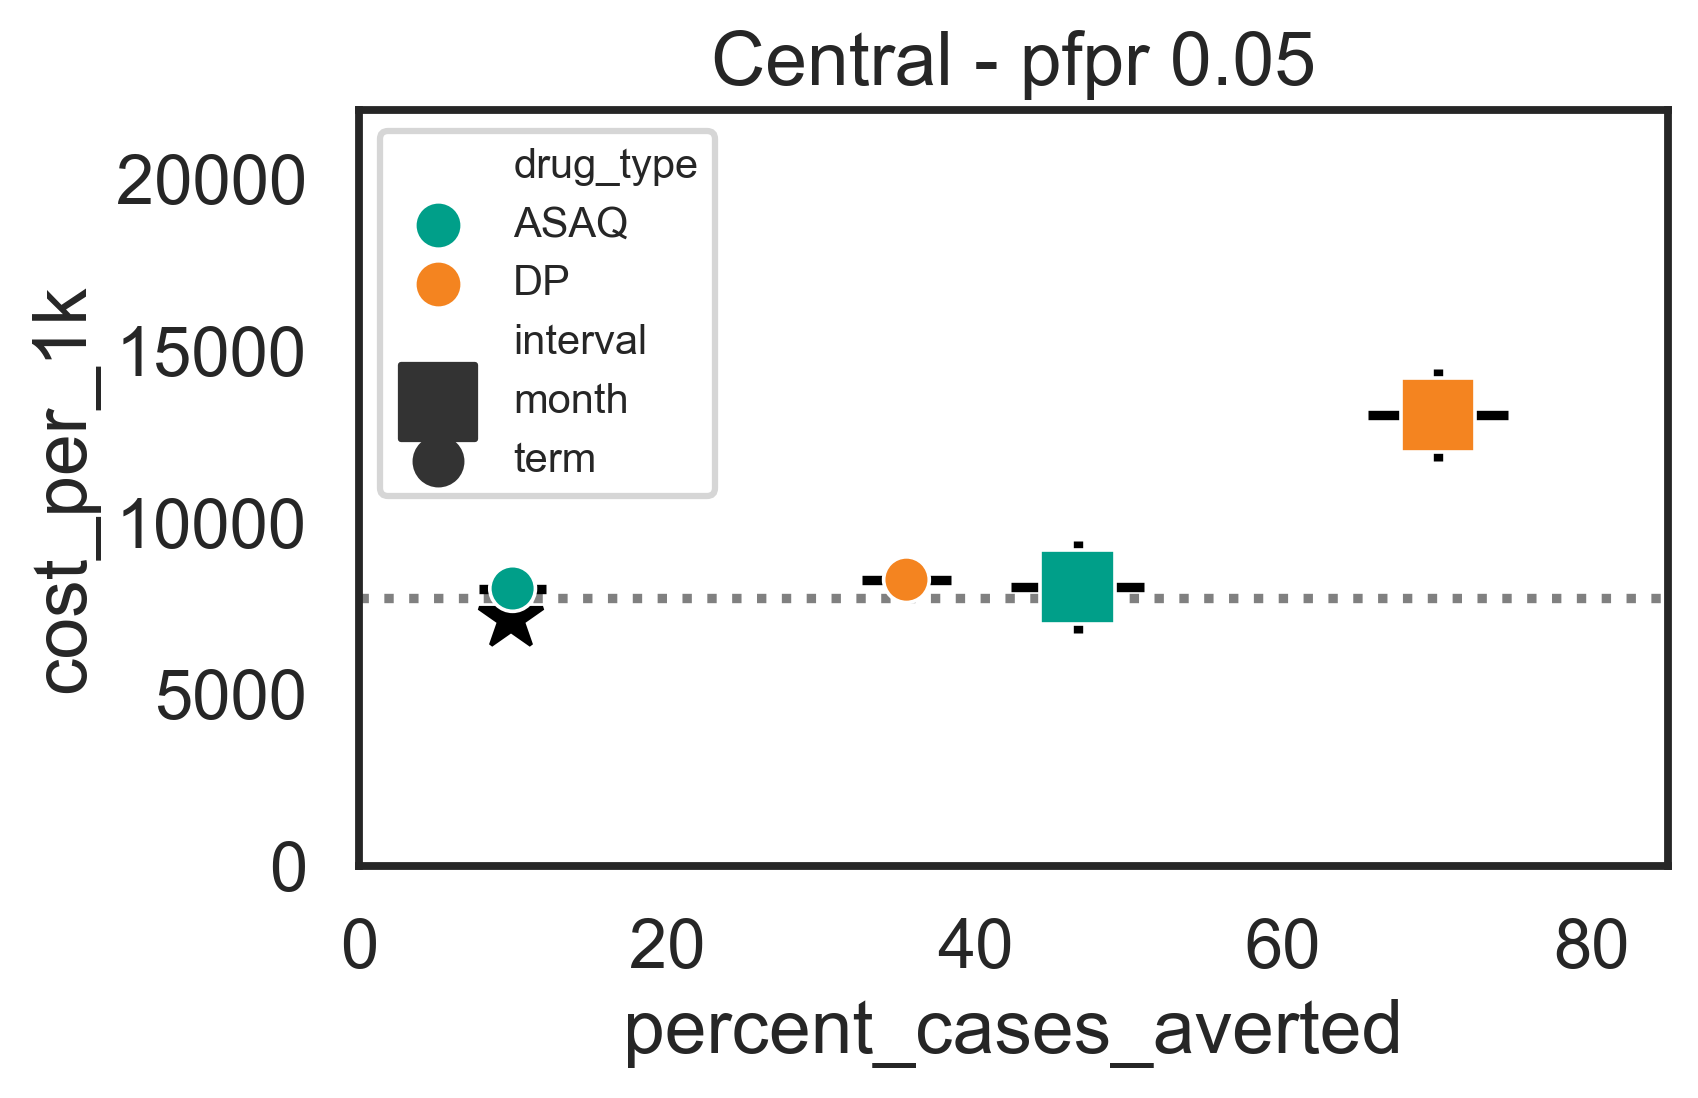

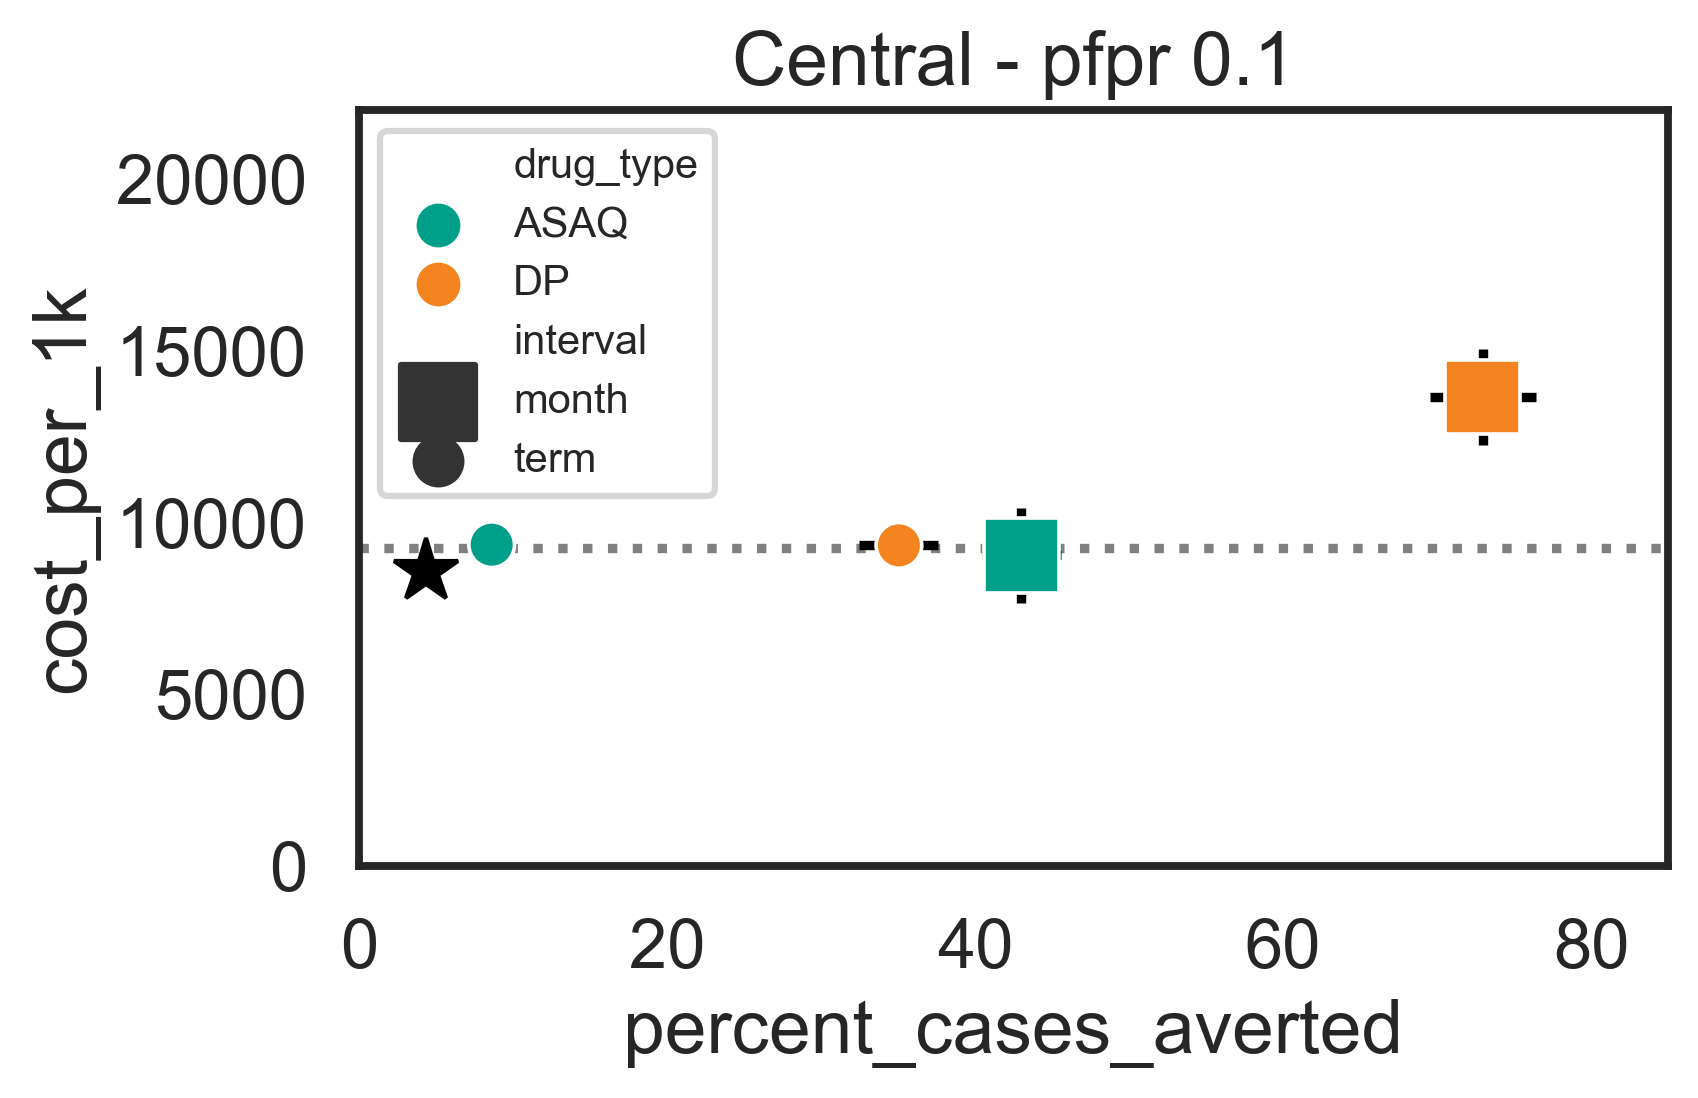

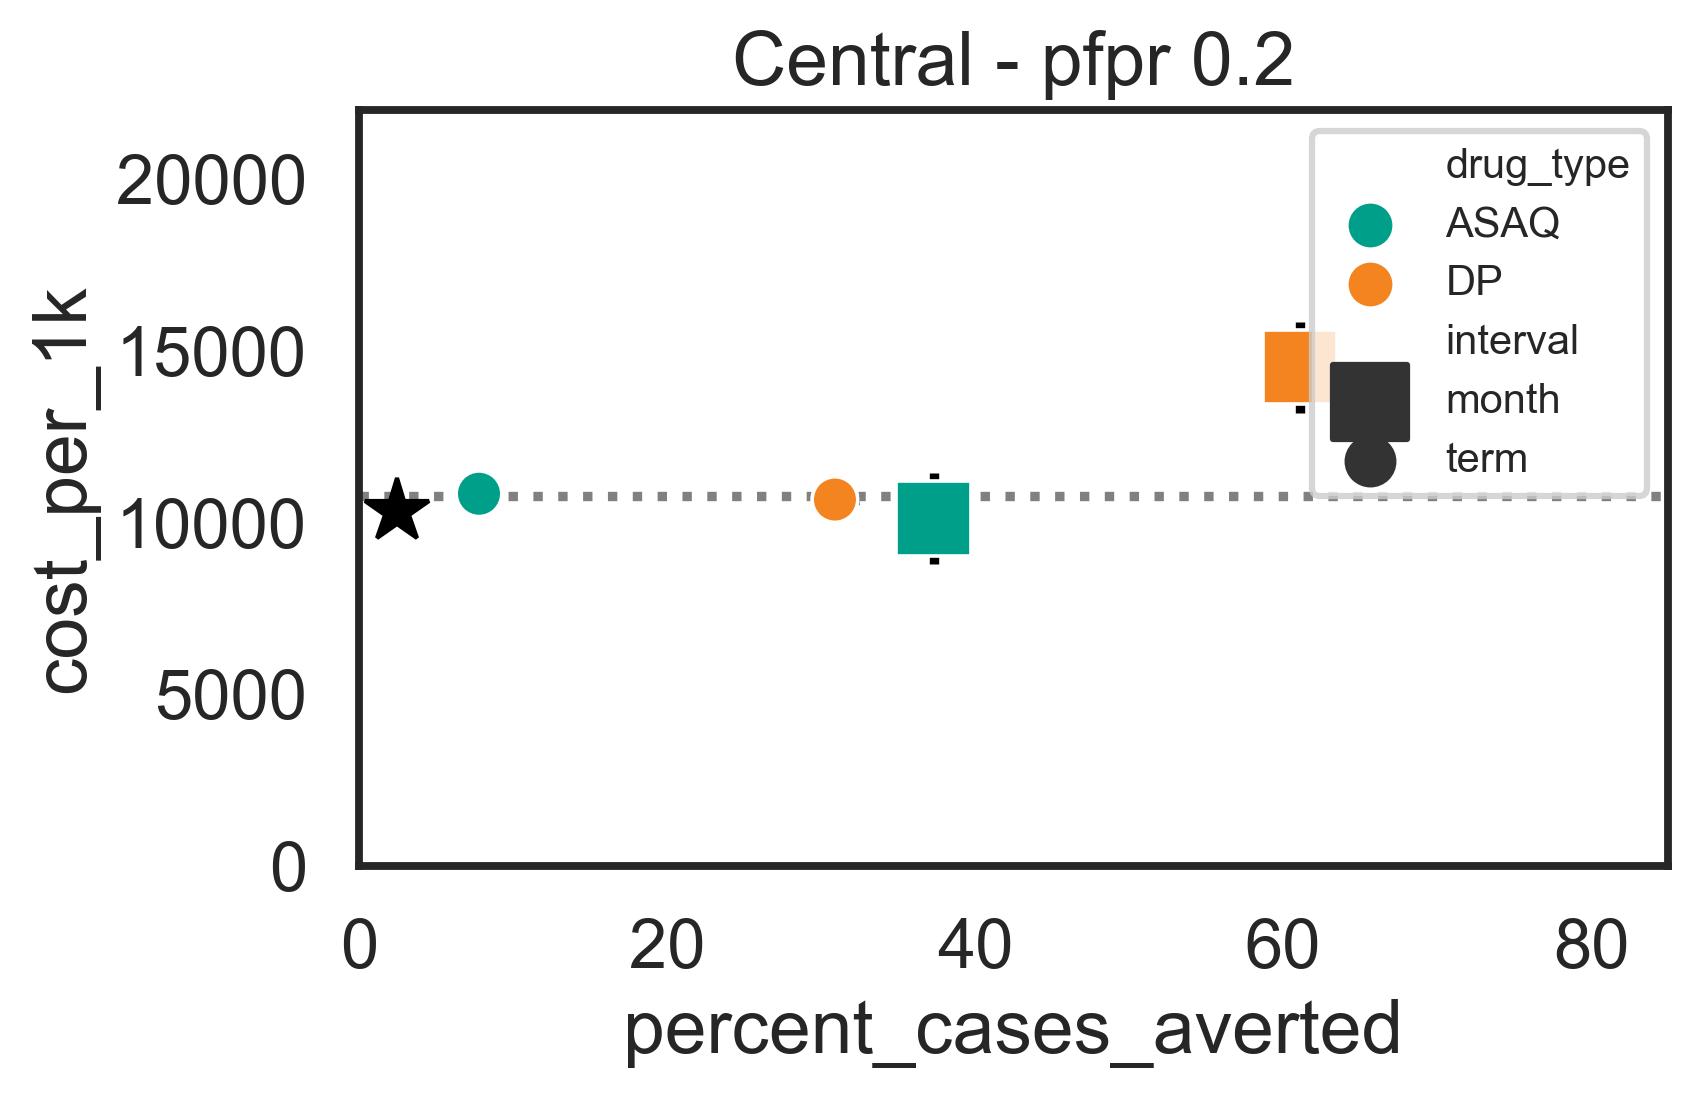

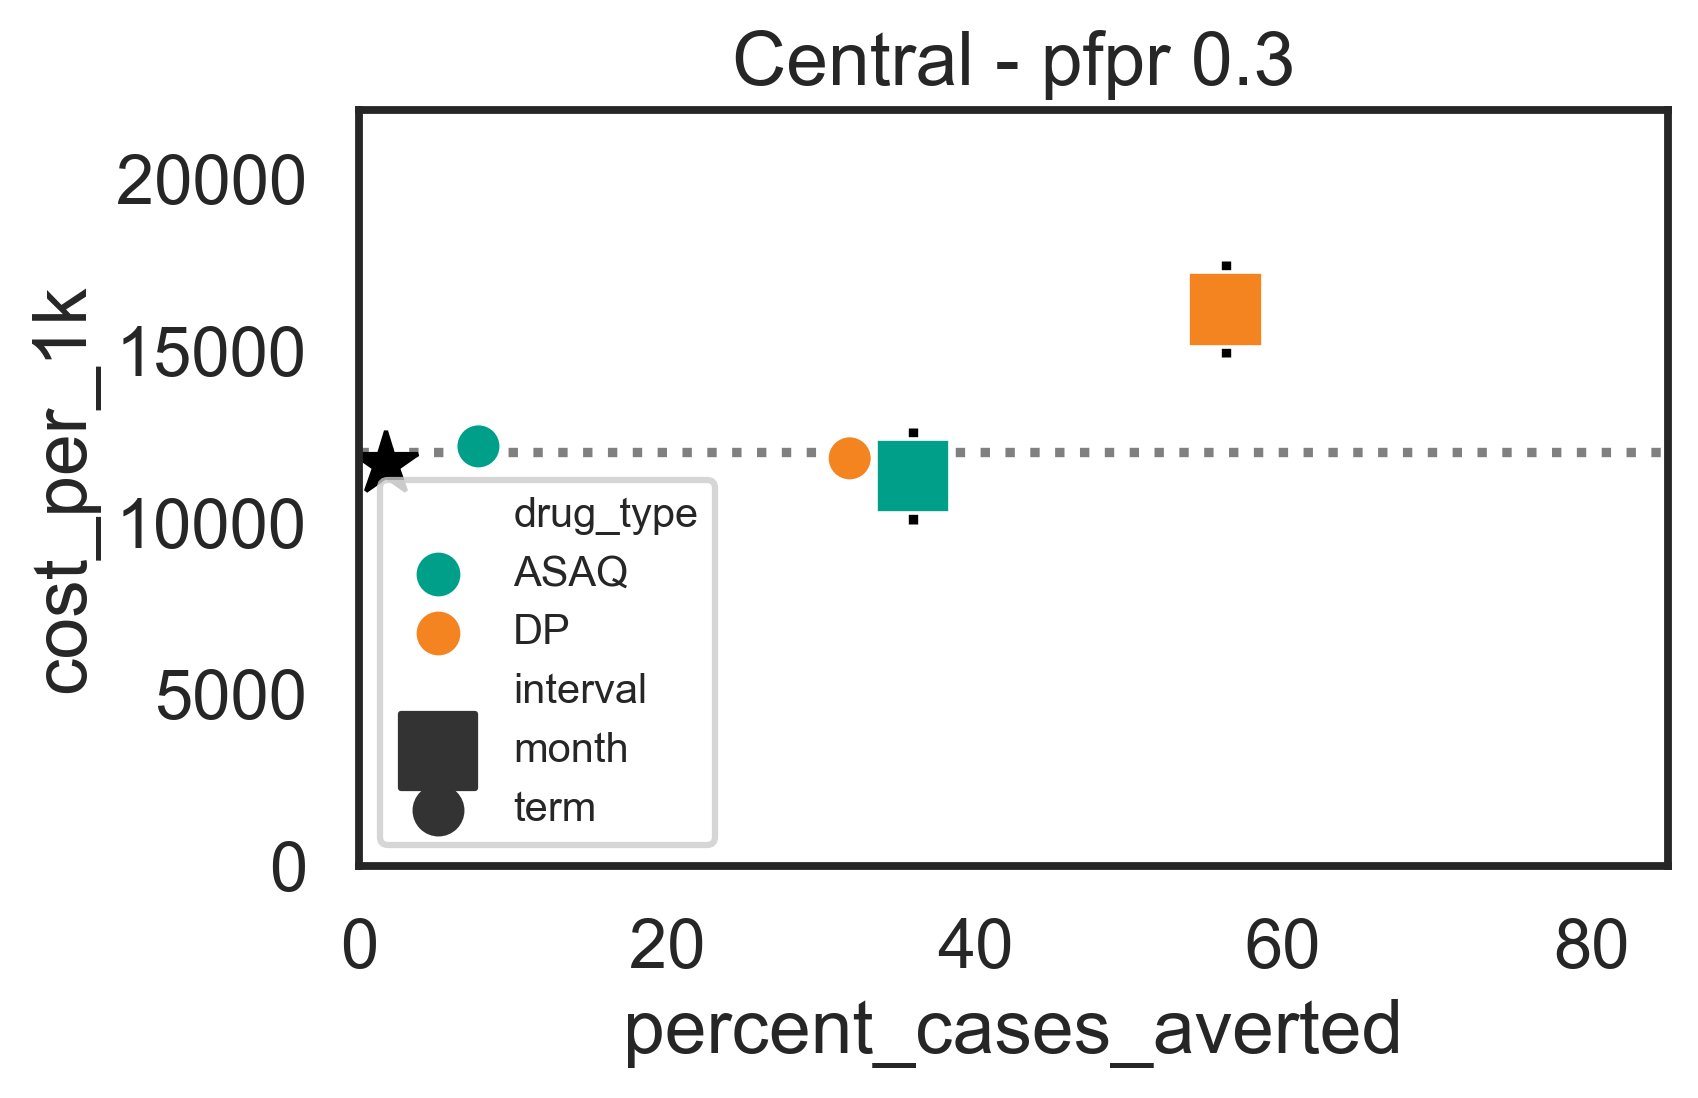

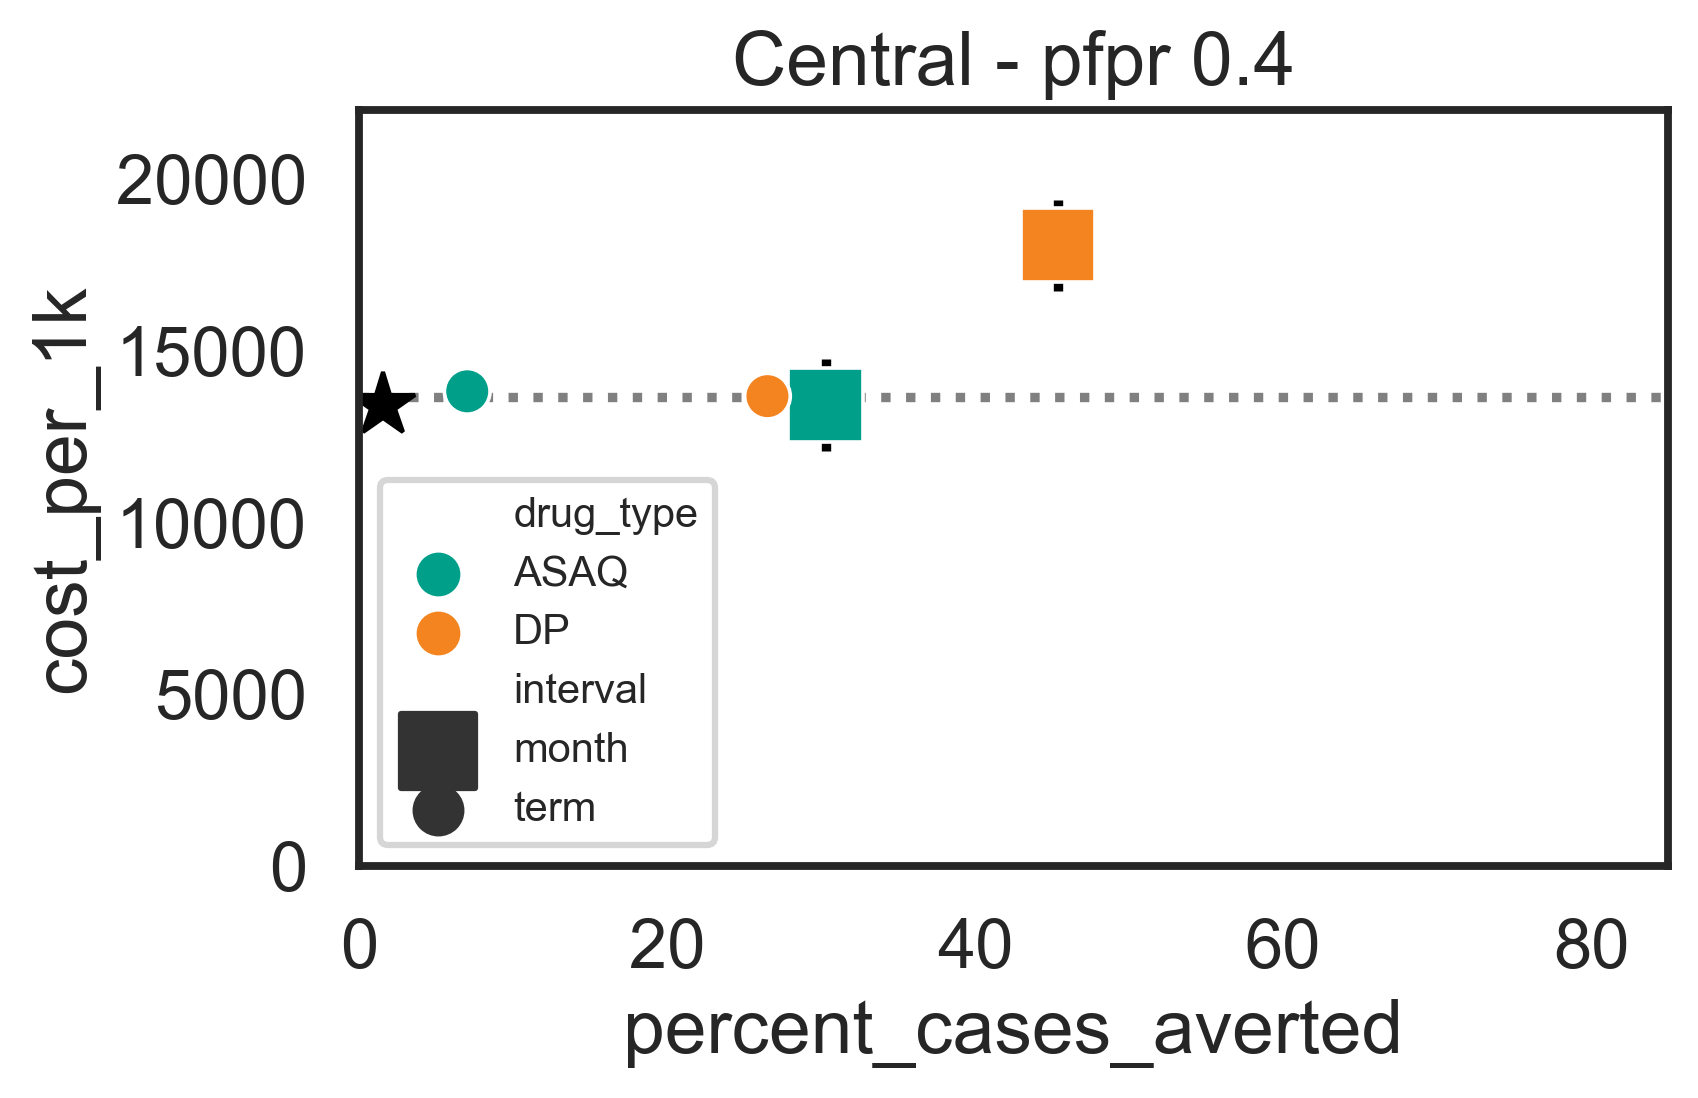

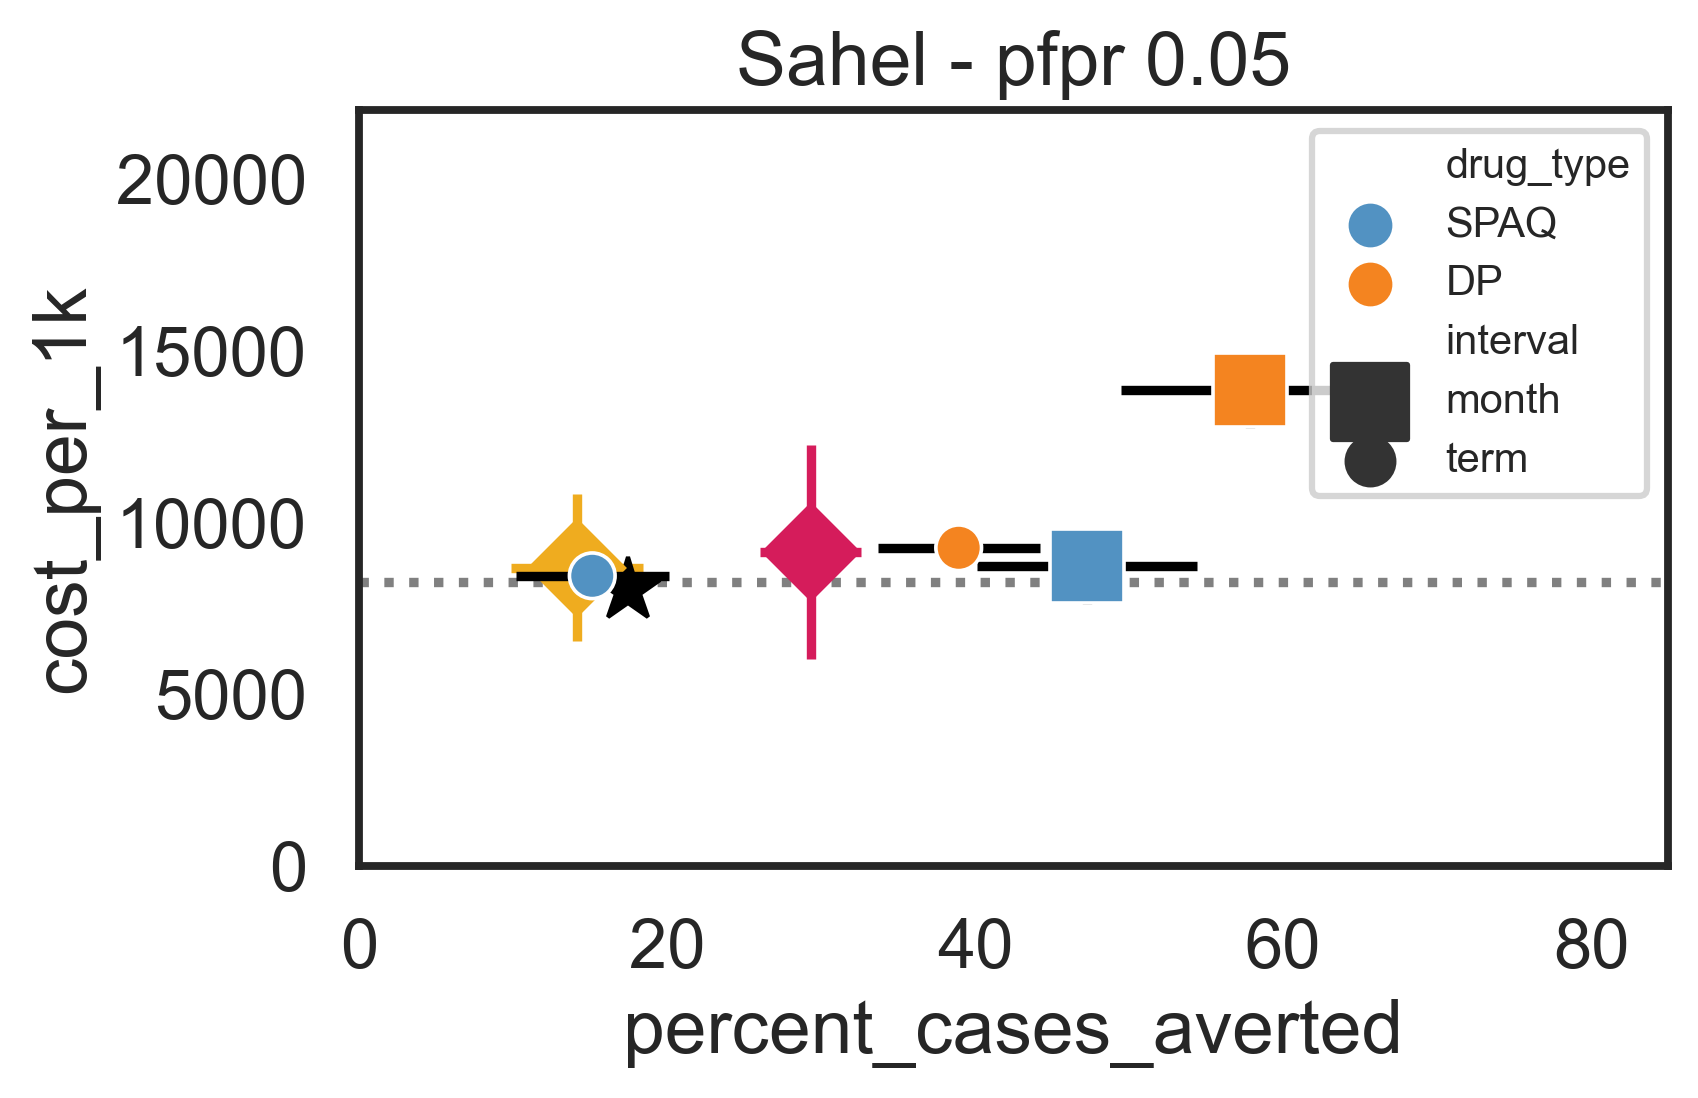

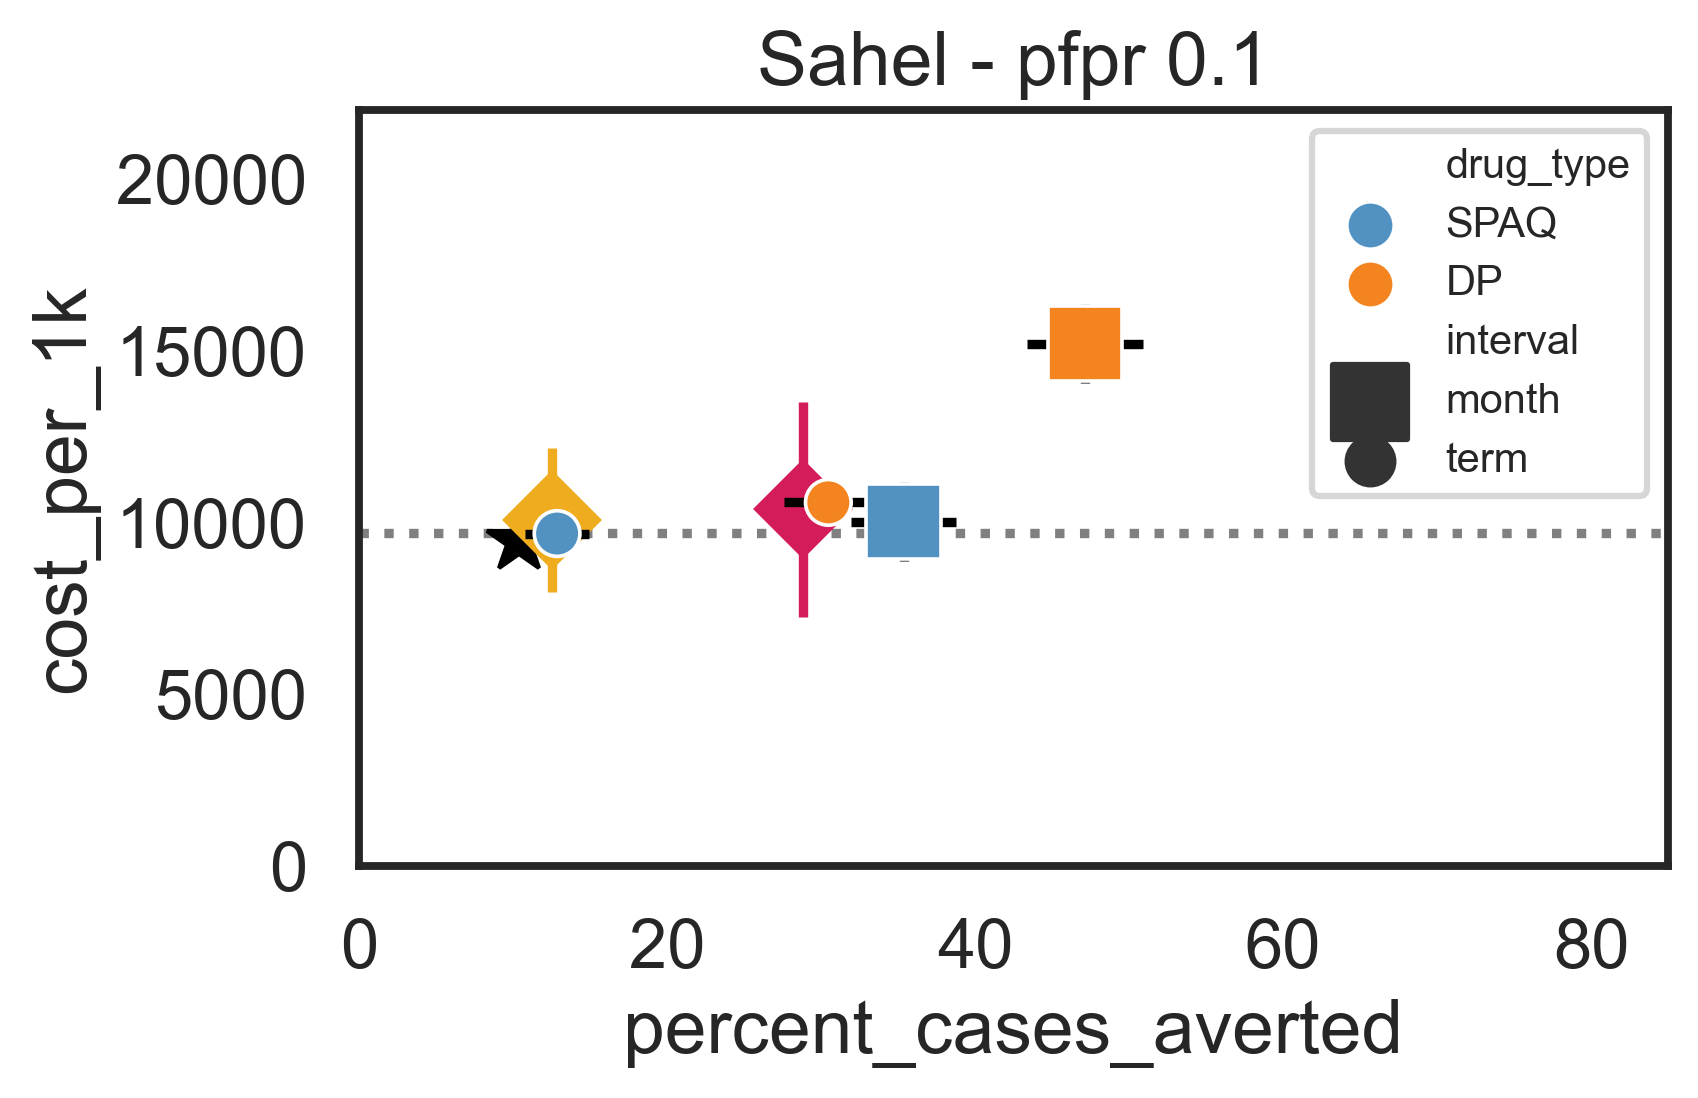

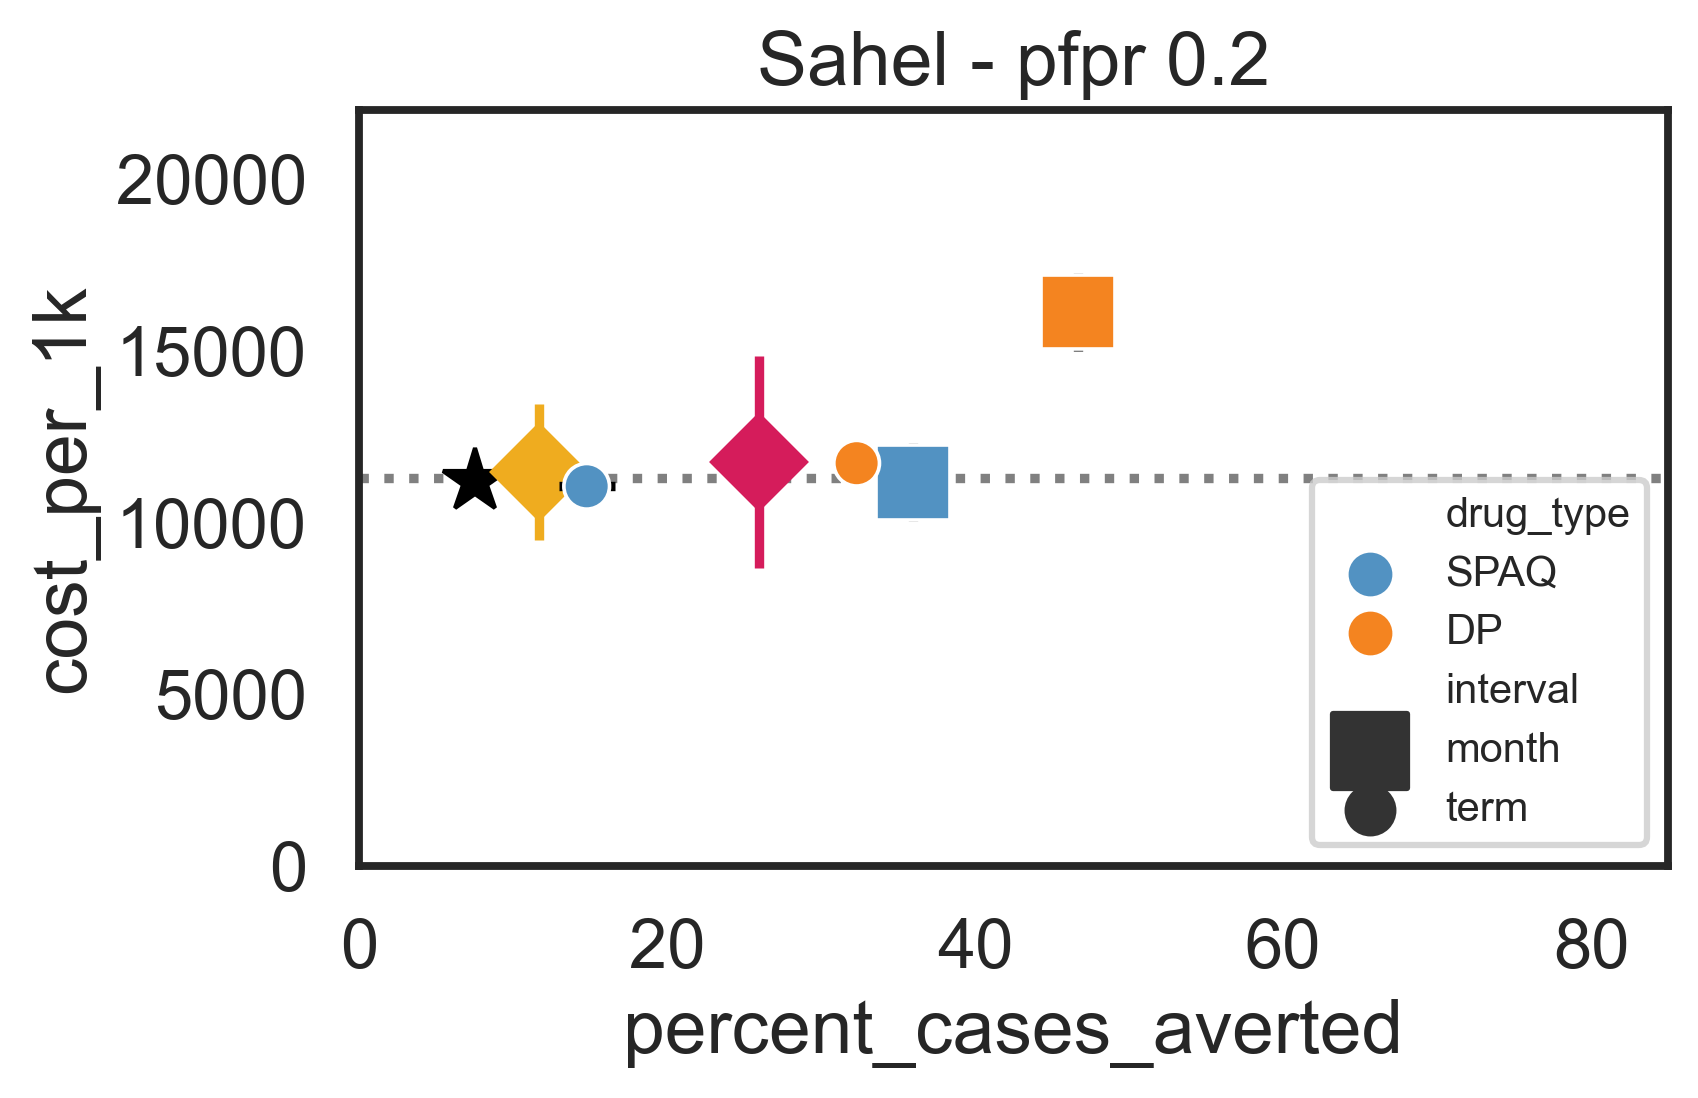

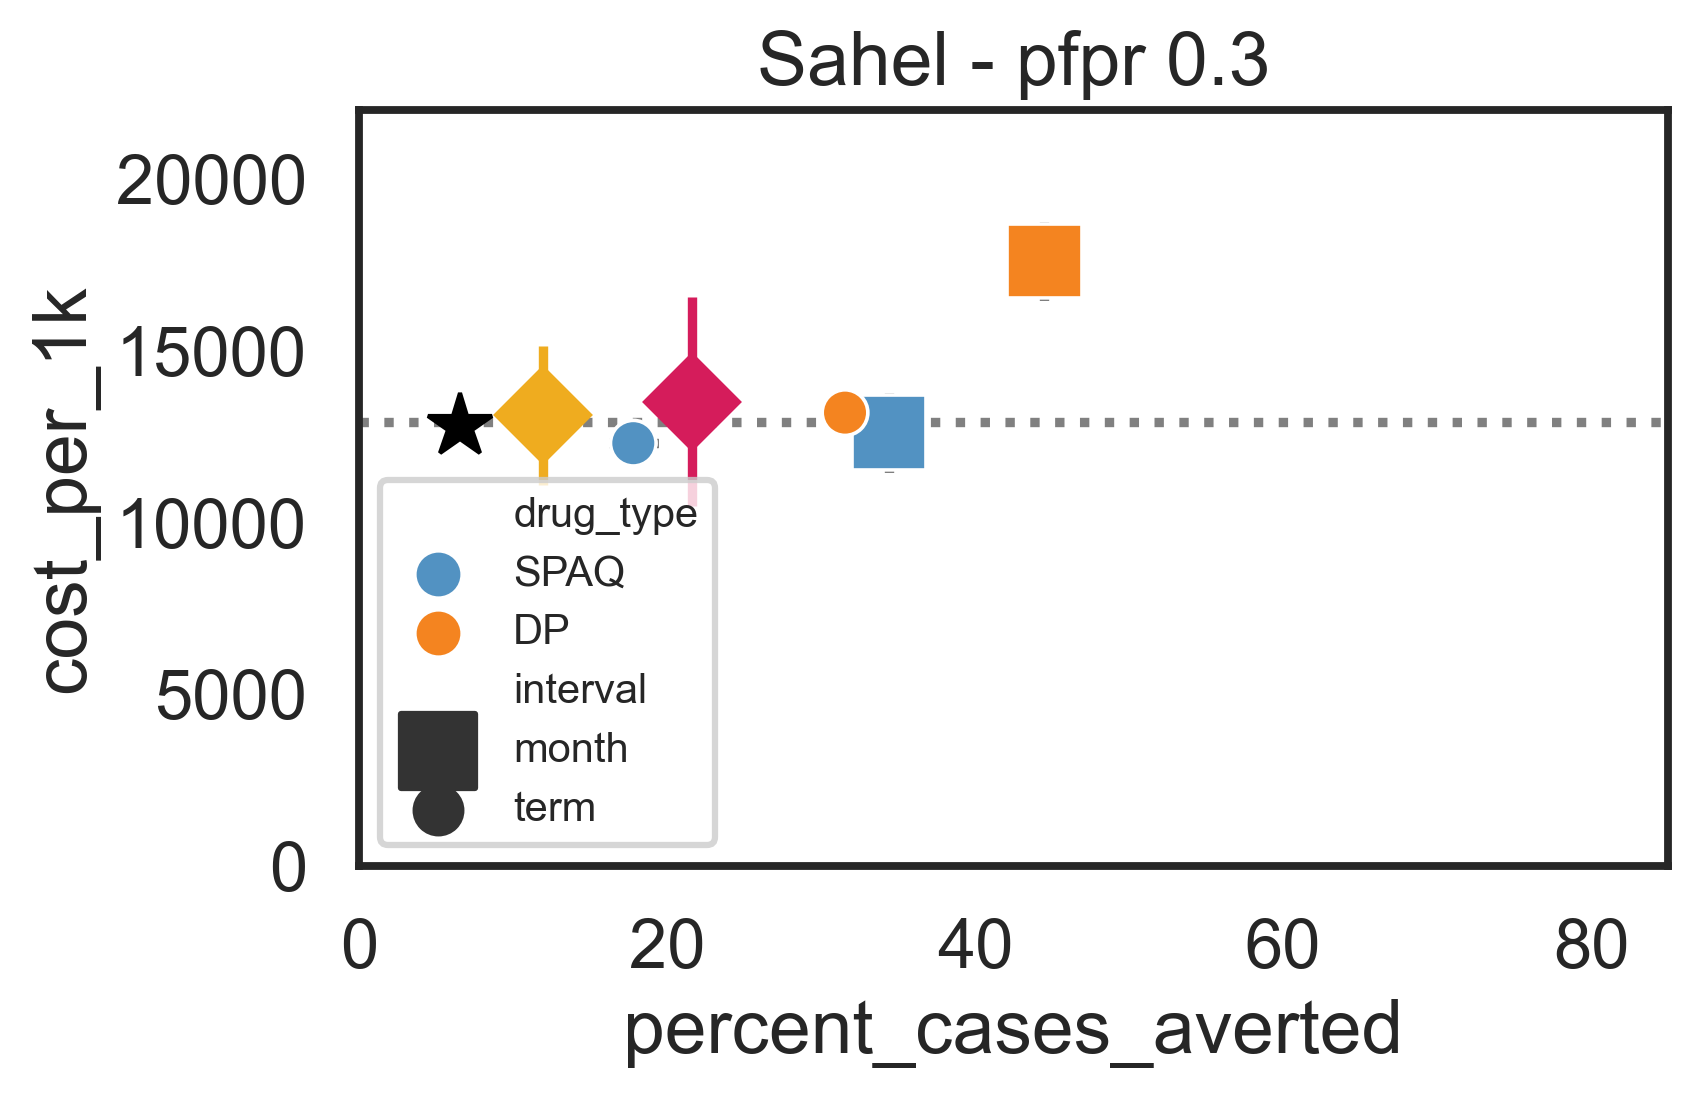

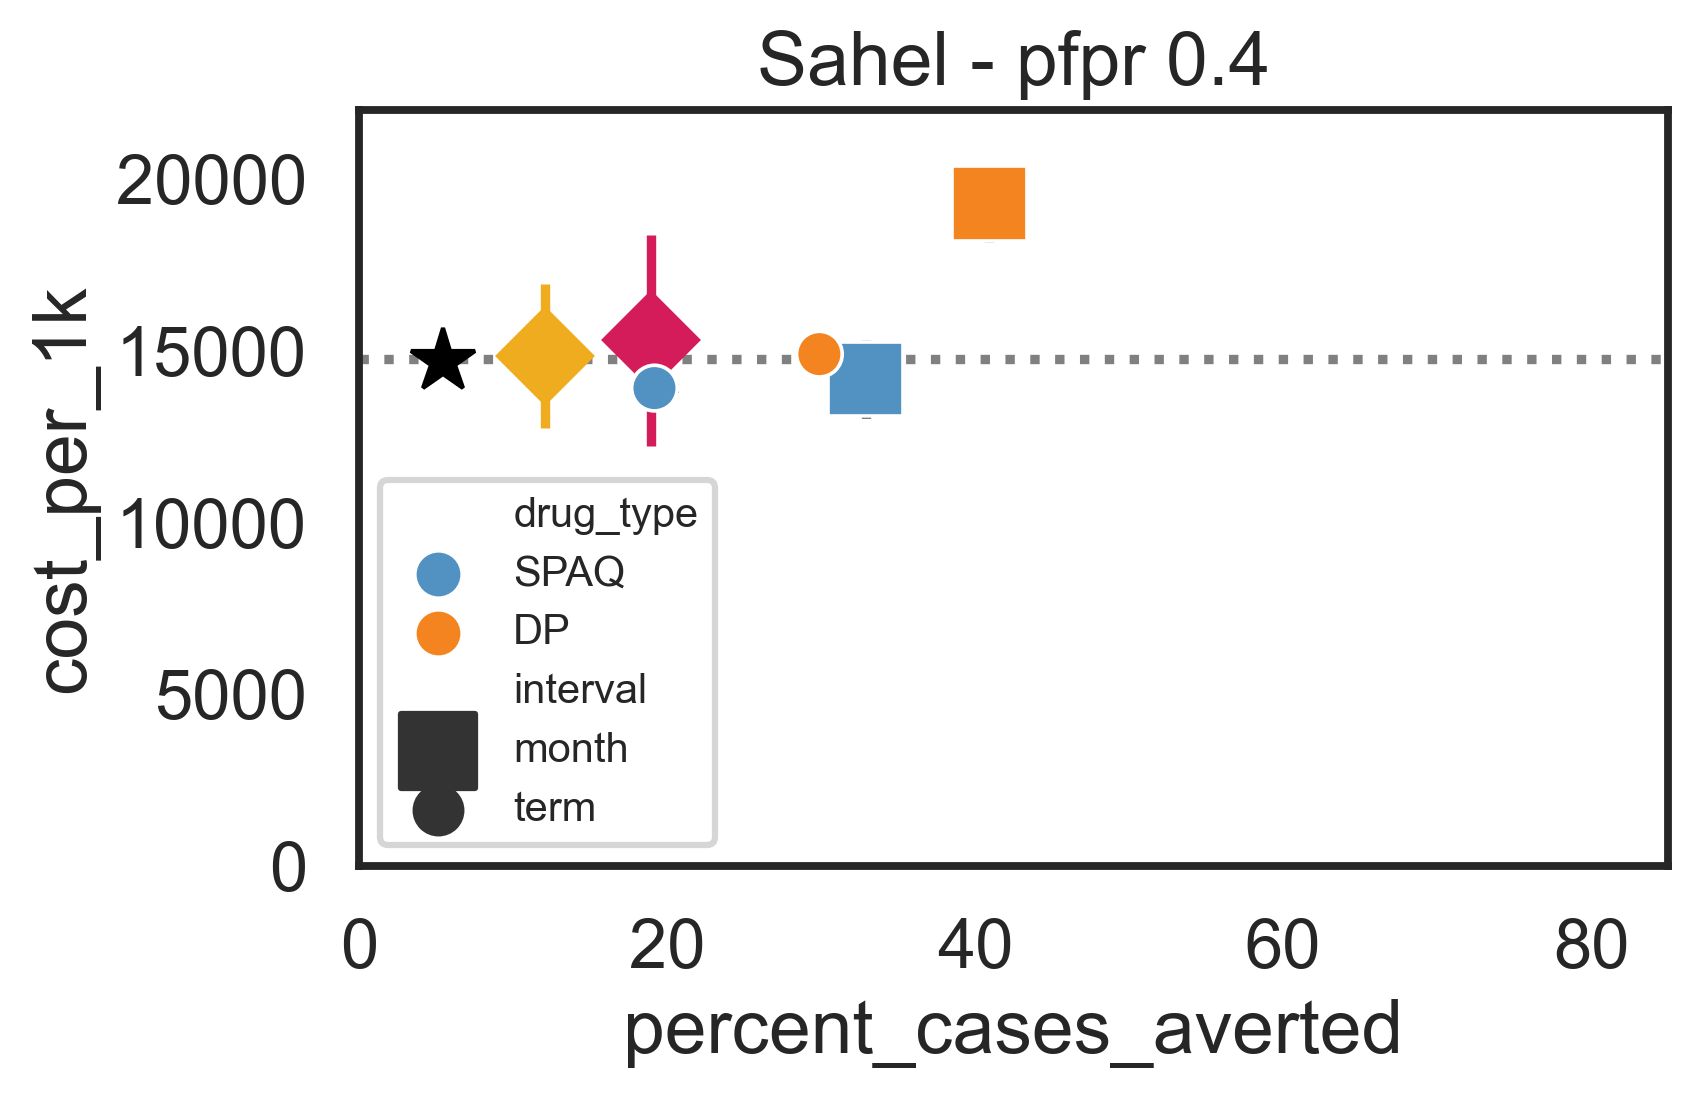

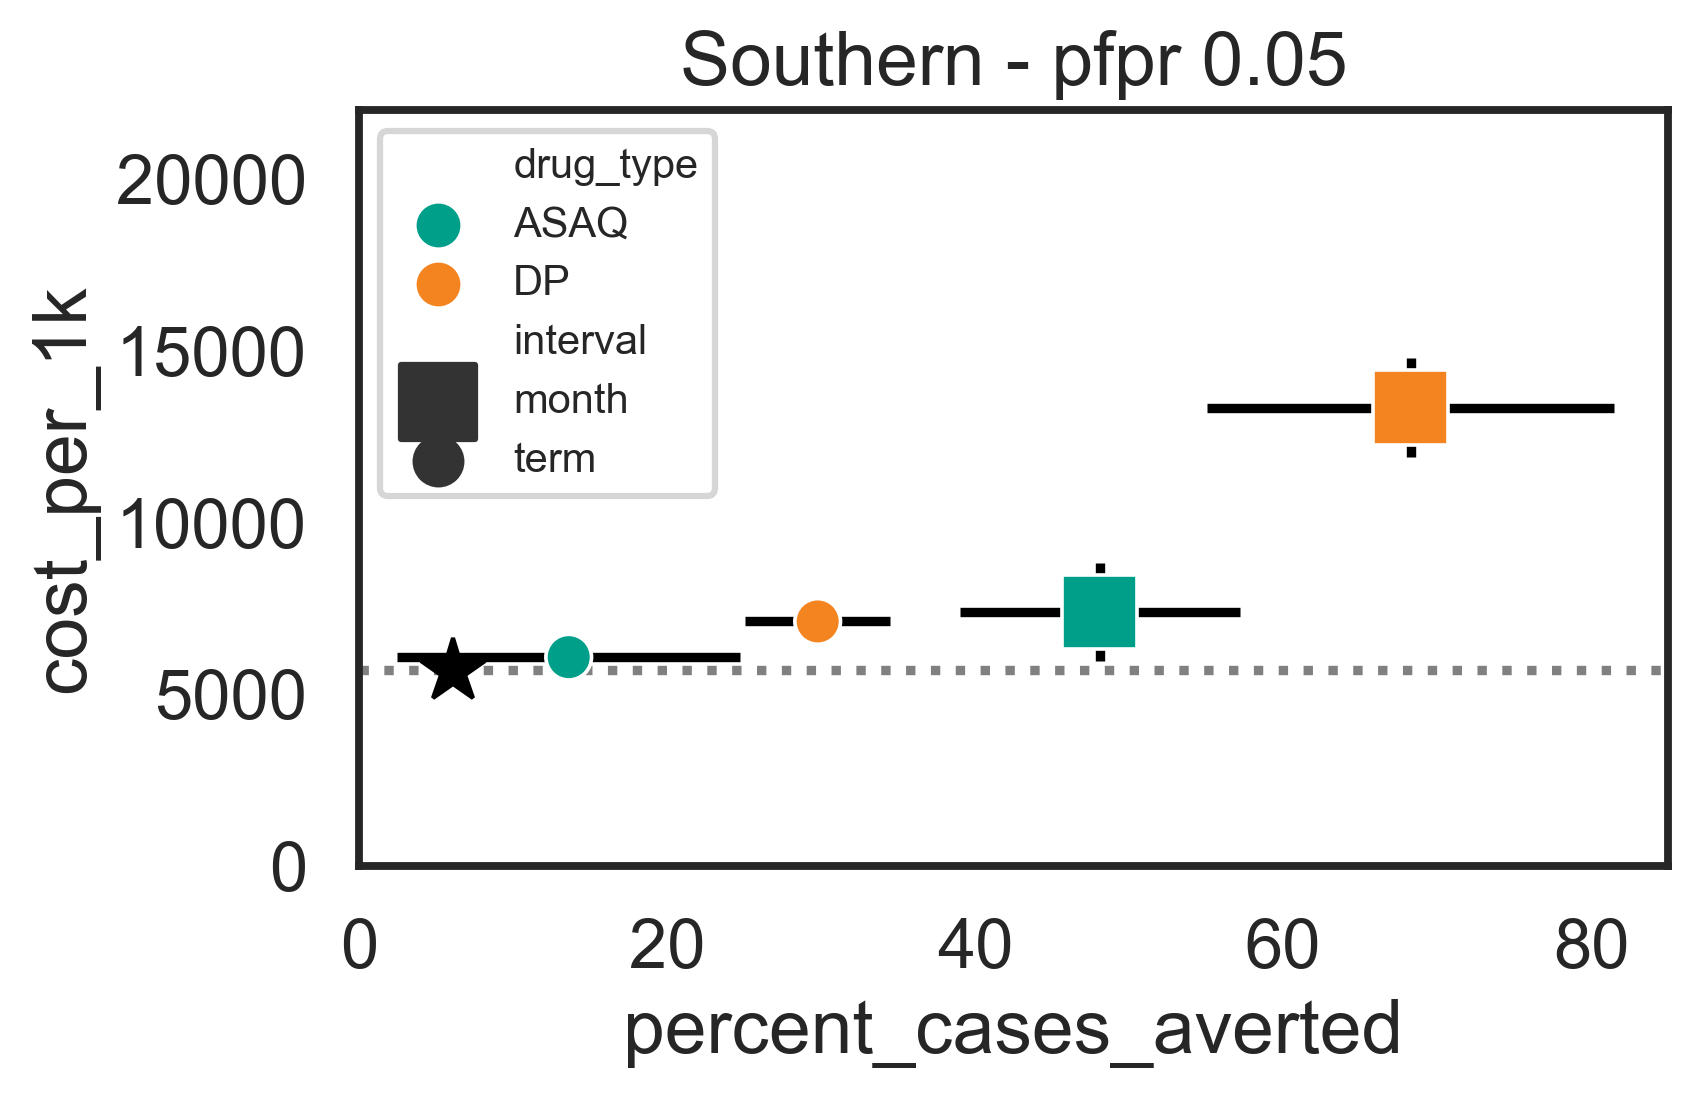

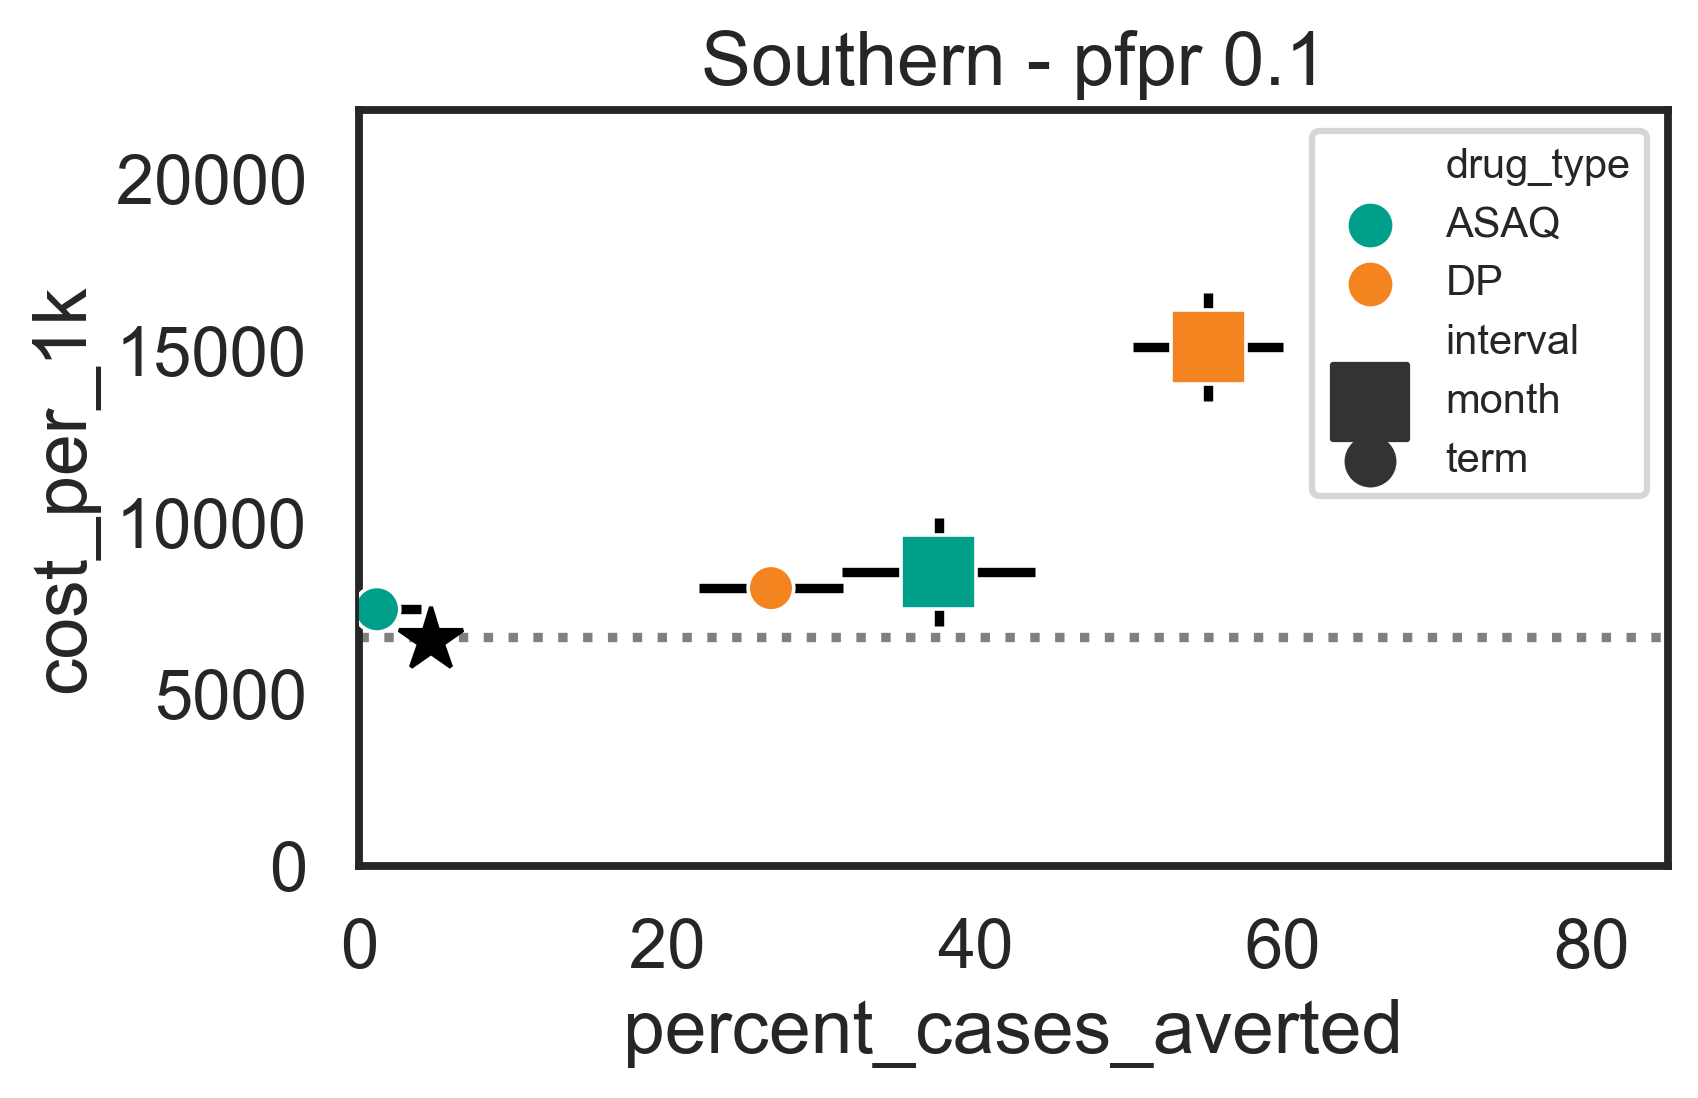

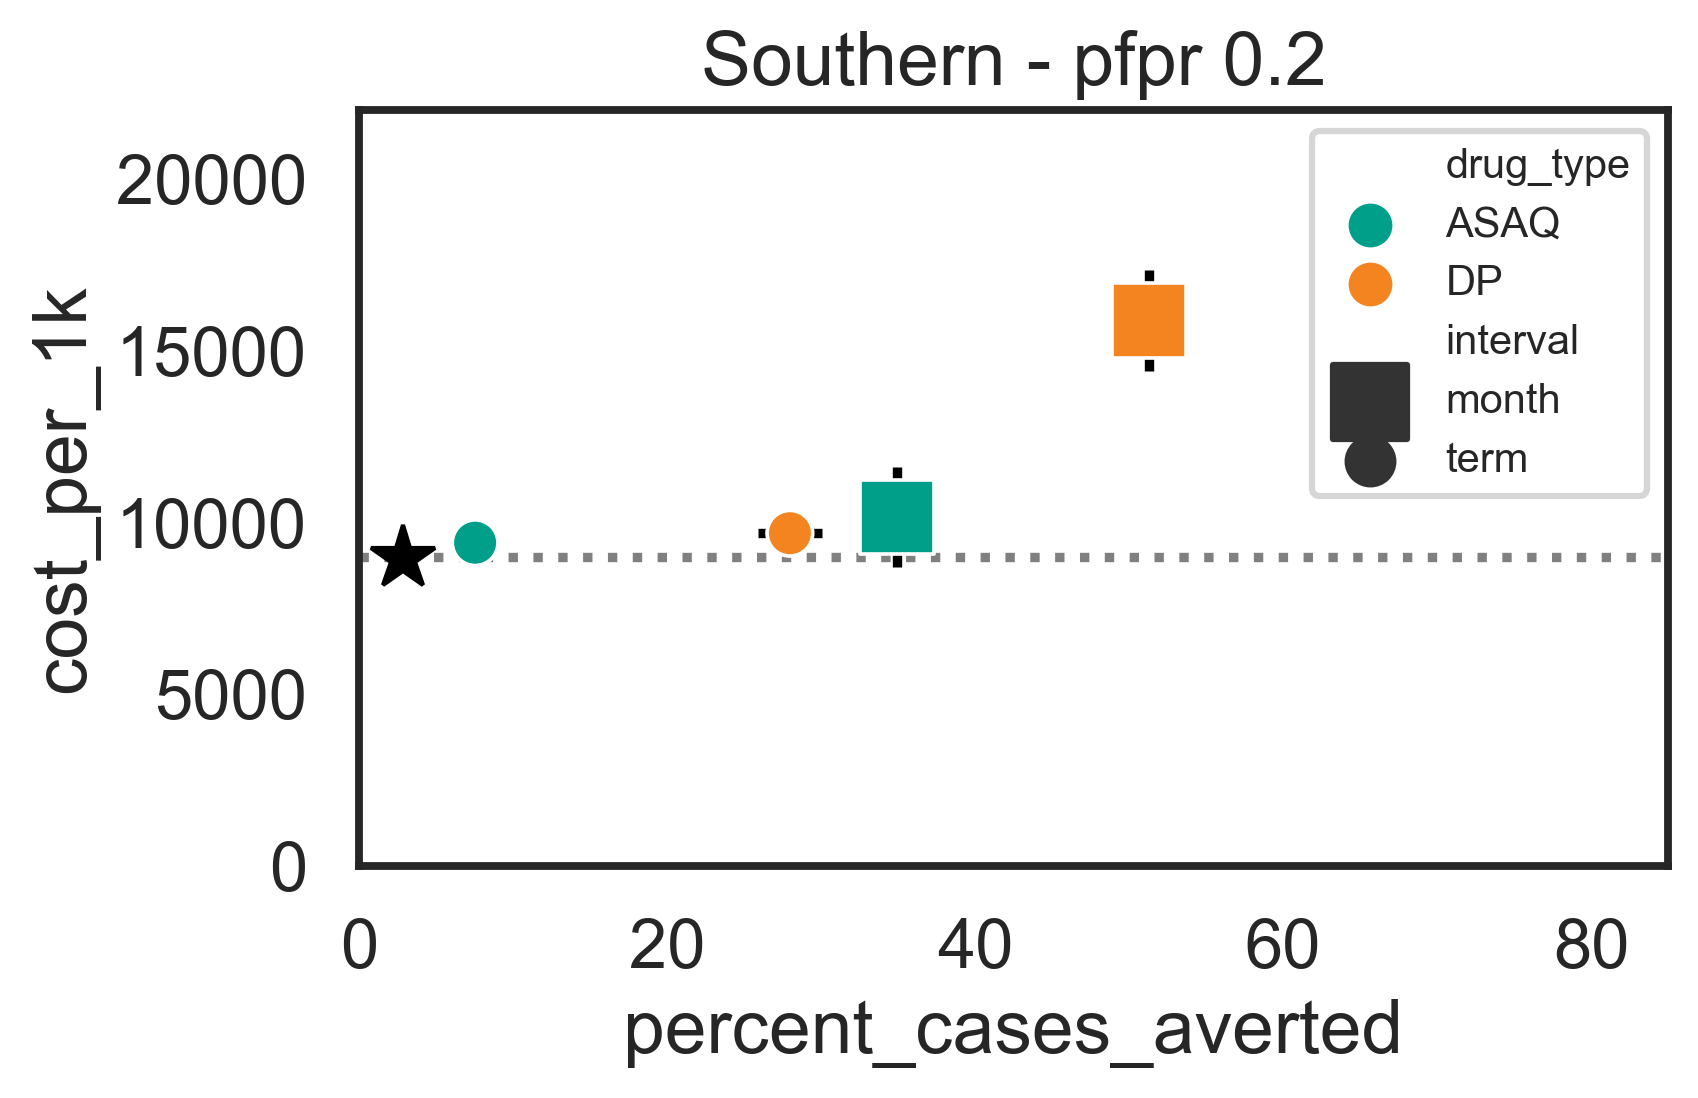

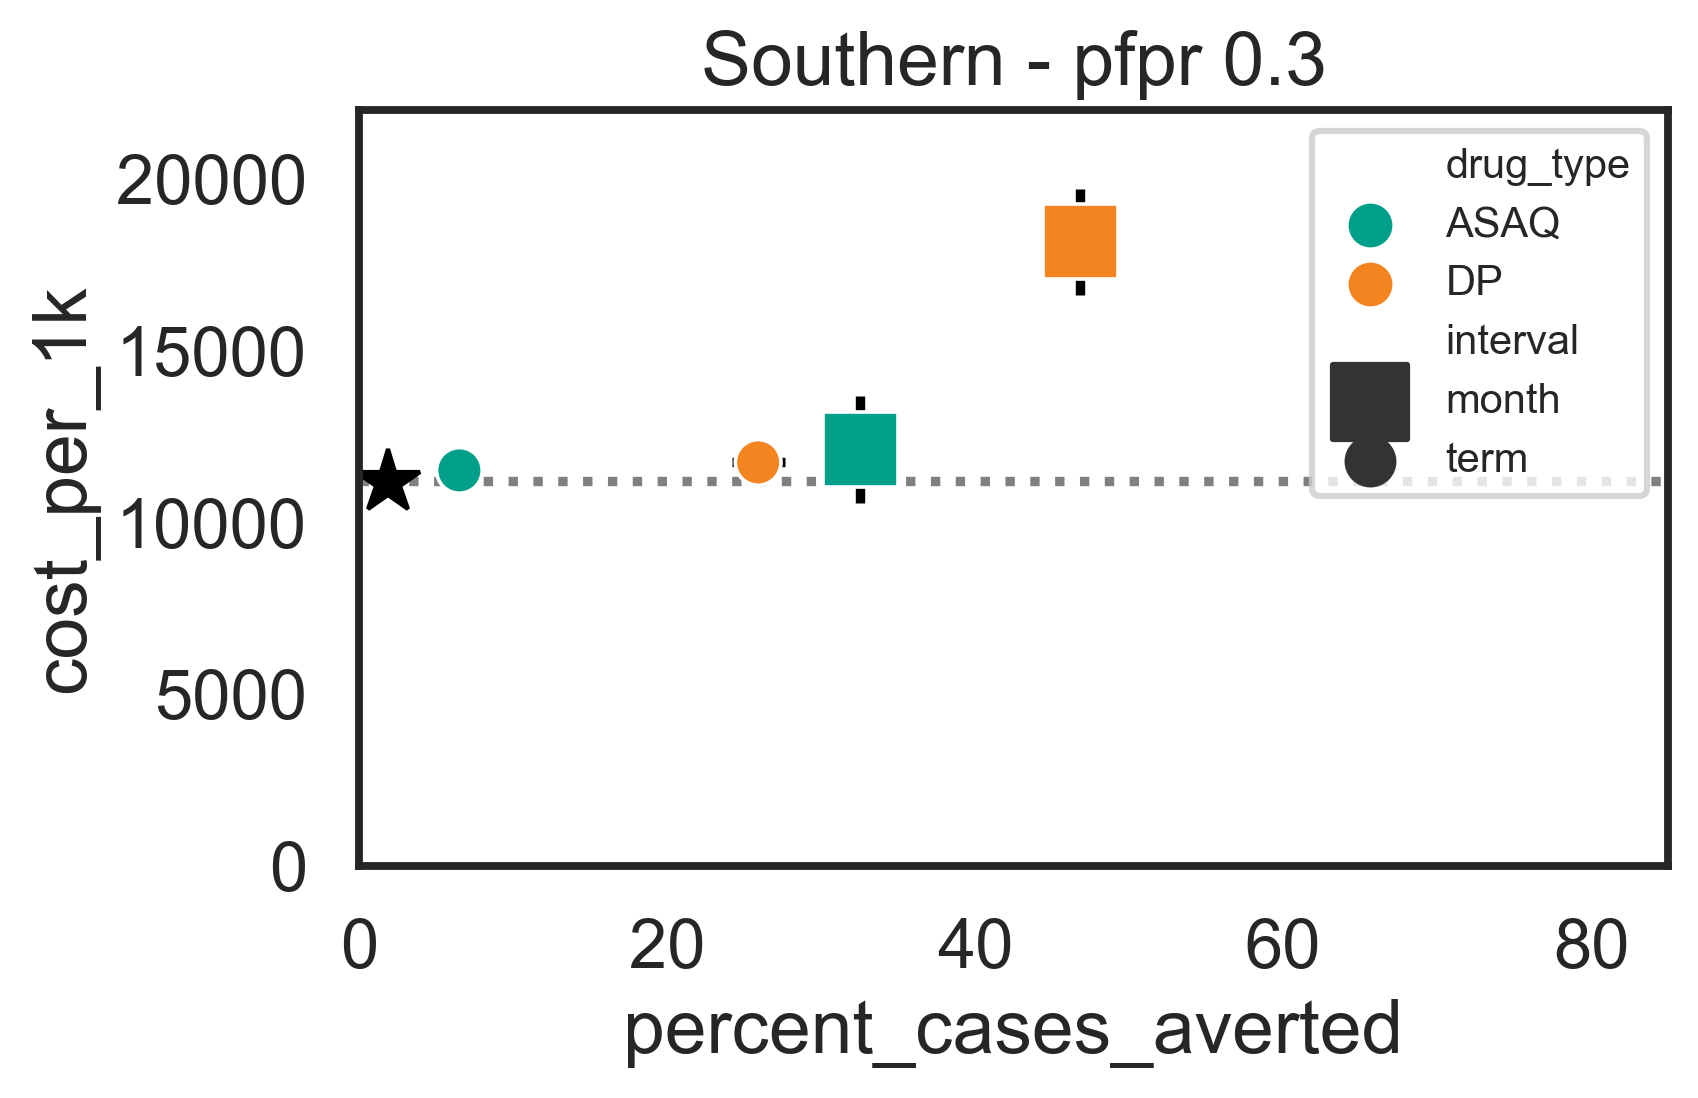

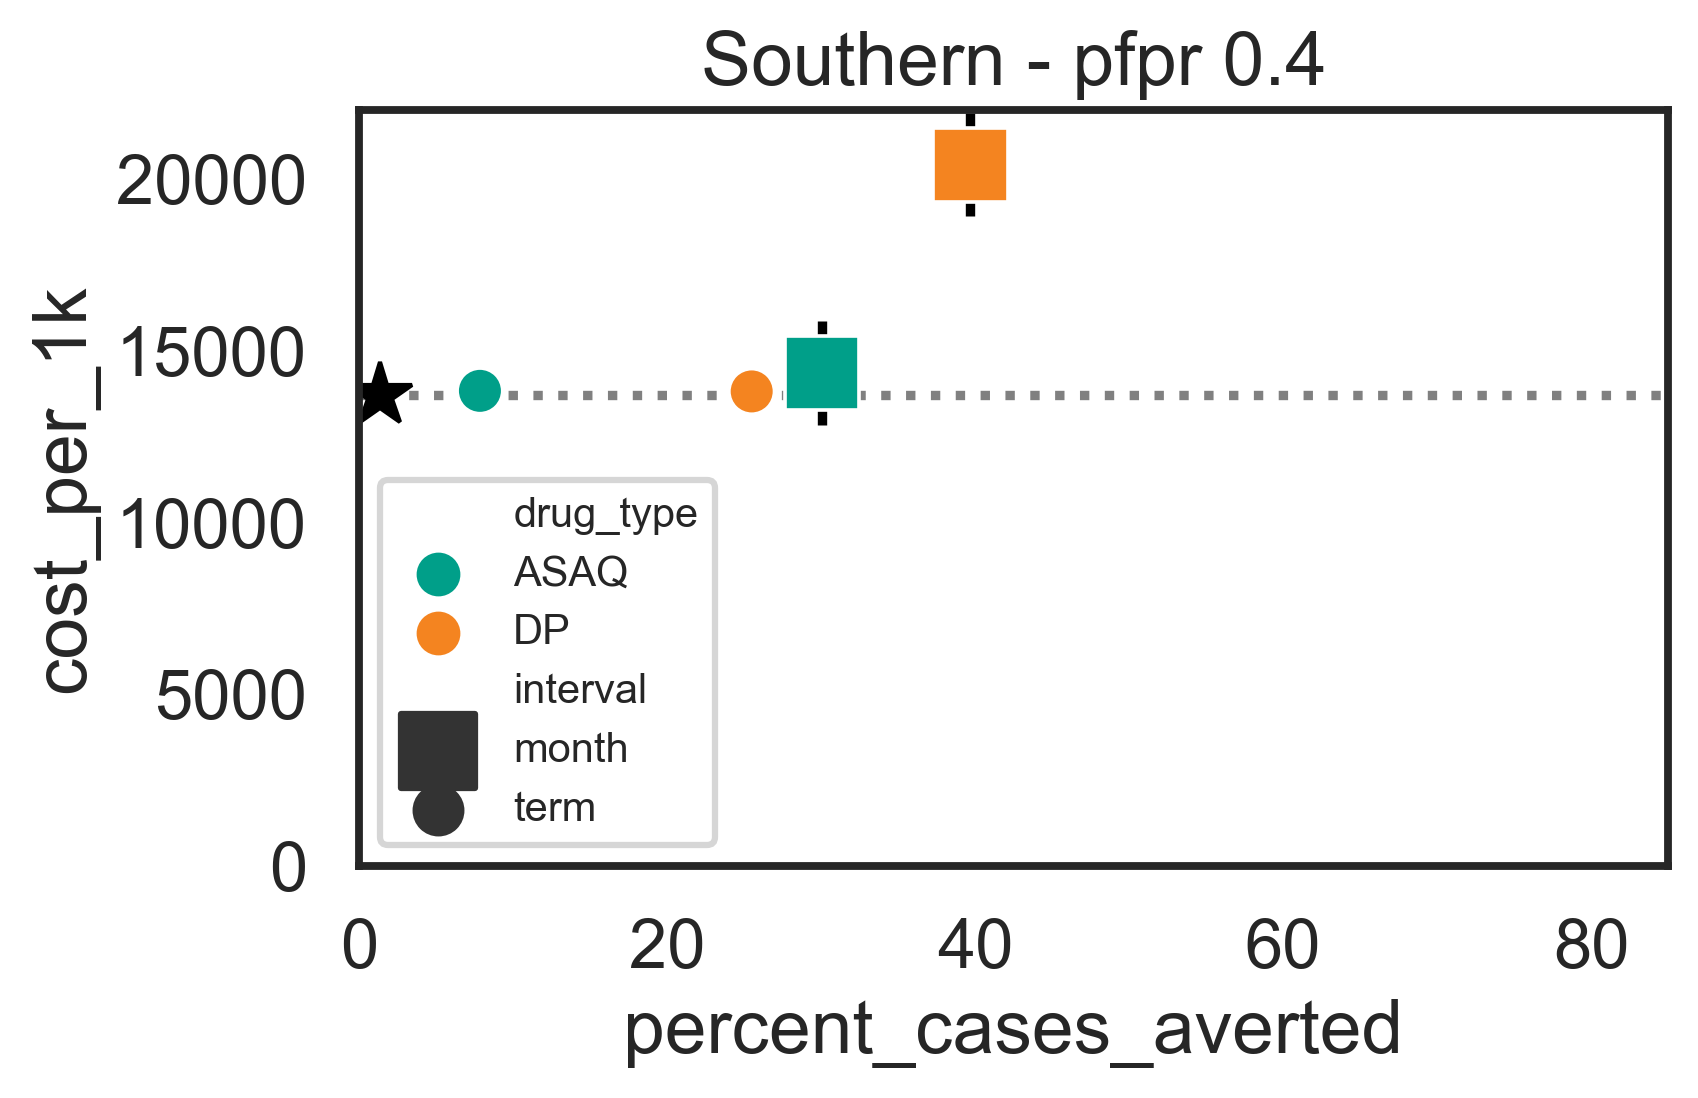

In [7]:
markersize=80

for a, sdf in df_scatterplot.groupby(["archetype", "transmission_level"]):
    plt.figure(dpi=300)
    sdf_without_no_iptsc = sdf[np.logical_not(sdf["scenario_number"]==30)]
    if a[0] == "Sahel":
        palette = ["#5292C2","#F48420"]
    else:
        palette = ["#009F89","#F48420"]
    sns.scatterplot(data=sdf_without_no_iptsc, x="percent_cases_averted", y="cost_per_1k", style="interval", hue="drug_type", size="interval", 
                    size_order=["month","term"], zorder=3, markers=["o","s"],palette=palette,sizes=(markersize*1.5,markersize*4))

    no_iptsc = sdf[sdf["scenario_number"]==30]
    plt.axhline(no_iptsc["cost_per_1k"].iloc[0], linestyle='dotted', color='gray', zorder=0)
    # plt.axhspan(no_iptsc["cost_low"].iloc[0]/5, no_iptsc["cost_high"].iloc[0]/5,
    #             alpha=0.2, color='gray', zorder=0)
    
    itn_sdf = df_scatterplot_itn[np.logical_and(df_scatterplot_itn["transmission_level"]==a[1],
                                                df_scatterplot_itn["archetype"]==a[0])]
    yerr = np.zeros([2,len(itn_sdf)])
    yerr[0:] = itn_sdf["cost_mean"]-itn_sdf["cost_low"]
    yerr[1:] = itn_sdf["cost_high"]-itn_sdf["cost_mean"]
    yerr /= 5.
    plt.errorbar(itn_sdf["percent_cases_averted"], 
         itn_sdf["cost_per_1k"], 
         # xerr=itn_sdf["frac_averted_clinical__all_STDEV"]*100,
         # yerr=yerr,
        linestyle="none", marker="*",
        color="black", zorder=1, markersize=markersize/5)

    yerr = np.zeros([2,len(sdf_without_no_iptsc)])
    yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low_IPTsc_only"]
    yerr[1:] = sdf_without_no_iptsc["cost_high_IPTsc_only"]-sdf_without_no_iptsc["cost_mean"]
    # yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low"]
    # yerr[1:] = sdf_without_no_iptsc["cost_high"]-sdf_without_no_iptsc["cost_mean"]
    yerr /= 5.

    plt.errorbar(sdf_without_no_iptsc["percent_cases_averted"], 
                 sdf_without_no_iptsc["cost_per_1k"], 
                 xerr=sdf_without_no_iptsc["frac_averted_clinical__all_STDEV"]*100,
                 yerr=yerr,
                linestyle="none",
                color="black", zorder=2)
    
    if a[0] == "Sahel":
        esmc_sdf = df_sahel_extra[df_sahel_extra["transmission_level"]==a[1]]
        
        
        for s, ssdf in esmc_sdf.groupby("scenario_number"):
            if s == 35:
                smc_color = "#EFAC1F"
            elif s == 36:
                smc_color = "#D51C5B"
            
            yerr = np.zeros([2,len(ssdf)])
            yerr[0:] = ssdf["cost_mean"]-ssdf["cost_low_SMC_only"]
            yerr[1:] = ssdf["cost_high_SMC_only"]-ssdf["cost_mean"]
            yerr /= 5.
            plt.errorbar(ssdf["percent_cases_averted"], 
                 ssdf["cost_per_1k"], 
                 xerr=ssdf["frac_averted_clinical__all_STDEV"]*100,
                 yerr=yerr,
                linestyle="none", marker="D",
                color=smc_color, zorder=1,markersize=markersize/5)
            # yerr = np.zeros([2,len(esmc_sdf)])
            # yerr[0:] = esmc_sdf["cost_mean"]-esmc_sdf["cost_low"]
            # yerr[1:] = esmc_sdf["cost_high"]-esmc_sdf["cost_mean"]
            # yerr /= 5.
            # plt.errorbar(esmc_sdf["percent_cases_averted"], 
            #      esmc_sdf["cost_per_1k"], 
            #      xerr=esmc_sdf["frac_averted_clinical__all_STDEV"]*100,
            #      yerr=yerr,
            #     linestyle="none", marker="D",
            #     color="purple", zorder=1)
    # plt.scatter(sdf["frac_averted_clinical__all"], sdf["cost"]

#     no_iptsc = sdf[sdf["scenario_number"]==30]
#     plt.axhline(no_iptsc["cost_per1kpop_peryear"].iloc[0], color='black', linestyle='dotted')

    plt.title(f"{a[0]} - pfpr {a[1]}") 
    plt.legend(fontsize=10)
    # plt.ylim([0,15000])
    # plt.xlim([0,1])
    plt.xlim([0,85])
    plt.ylim([0,22000])
    ax = plt.gca()
    plt.yticks([0,5000,15000,10000,20000])
    # plt.yticks([0,5000,15000,10000,20000,25000])

    plt.tight_layout()
    # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.png")
    # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.pdf")
    # plt.close("all")

# Single-figure version

In [8]:
set(df_scatterplot["transmission_level"])

{0.05, 0.1, 0.2, 0.3, 0.4}

In [12]:
archetypes = ["Sahel", "Central", "Southern"]
df_scatterplot["archetype"] = pd.Categorical(df_scatterplot["archetype"], categories = archetypes, ordered=True)

C:\Users\joshsu\AppData\Local\Temp/ipykernel_26664/3737707875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scatterplot["archetype"] = pd.Categorical(df_scatterplot["archetype"], categories = archetypes, ordered=True)


In [13]:
for a, sdf in df_scatterplot.groupby(["archetype", "transmission_level"]):
    print(a)

('Sahel', 0.05)
('Sahel', 0.1)
('Sahel', 0.2)
('Sahel', 0.3)
('Sahel', 0.4)
('Central', 0.05)
('Central', 0.1)
('Central', 0.2)
('Central', 0.3)
('Central', 0.4)
('Southern', 0.05)
('Southern', 0.1)
('Southern', 0.2)
('Southern', 0.3)
('Southern', 0.4)


In [37]:
from copy import copy

meta NOT subset; don't know how to subset; dropped


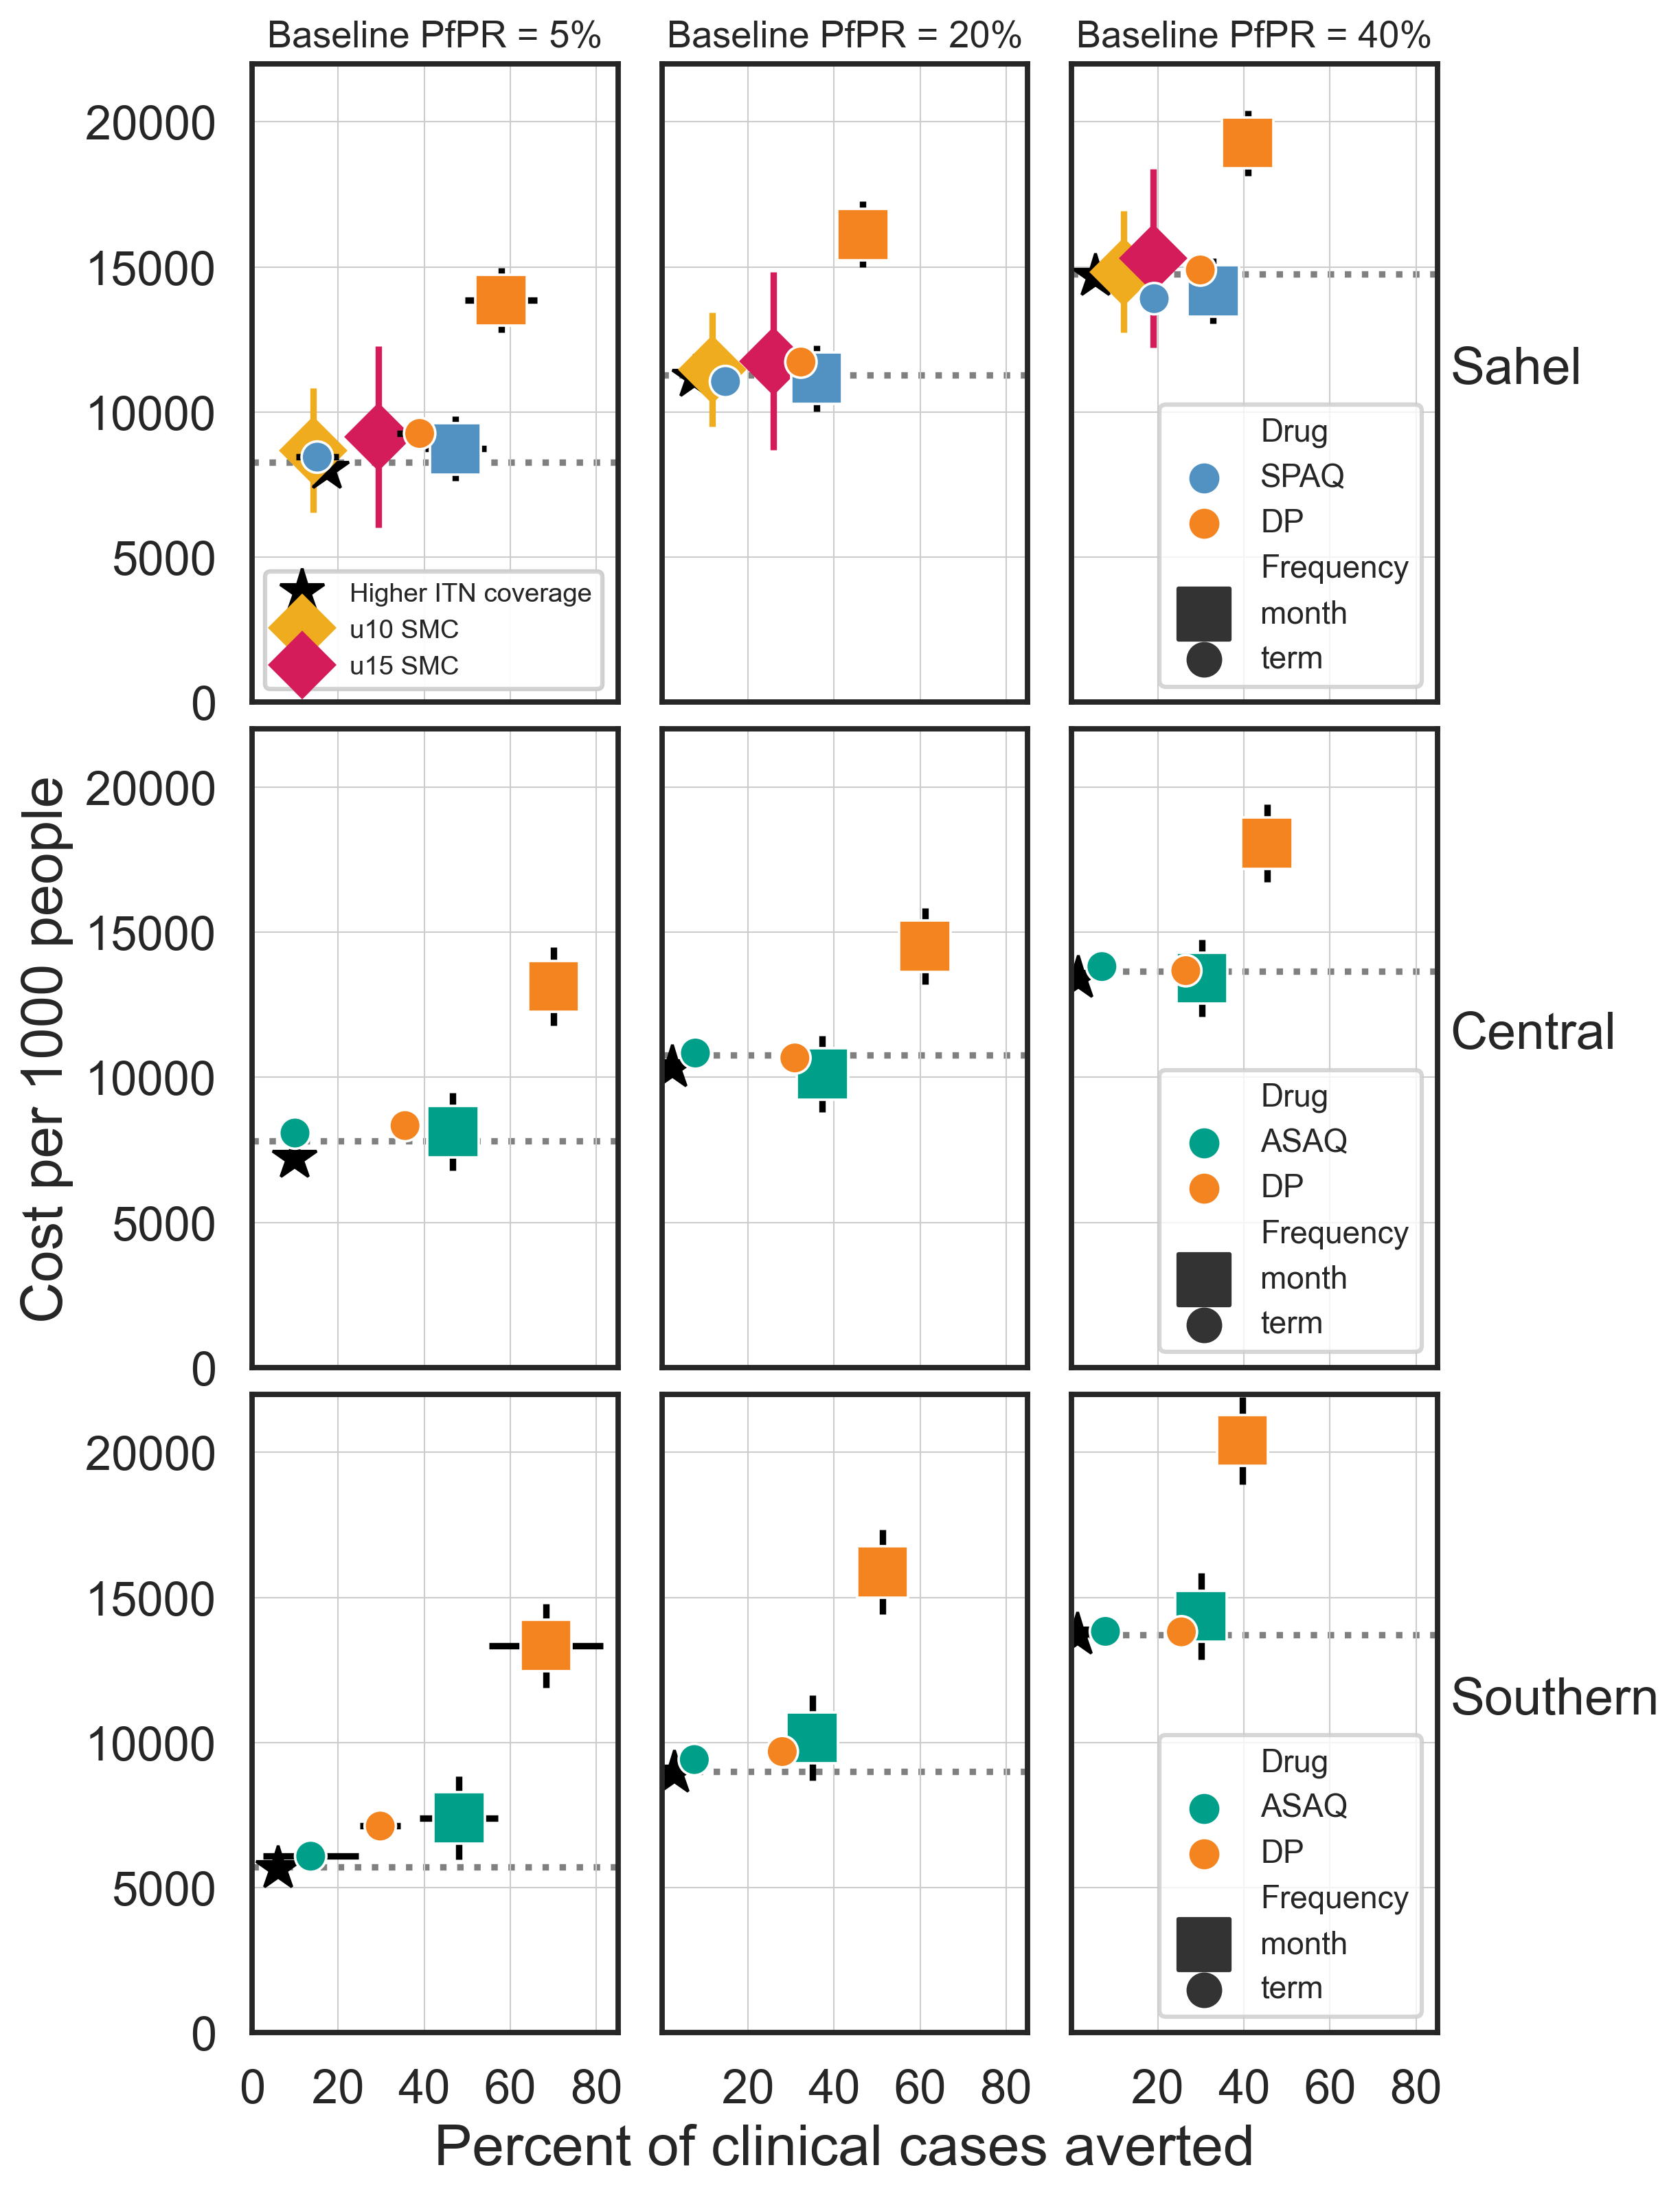

In [62]:
markersize=80

df_single_scatterplot = df_scatterplot.copy().rename(columns={"drug_type": "Drug", "interval": "Frequency"})

plt.figure(dpi=300, figsize=(8.5,11))

i = 1
for a, sdf in df_single_scatterplot.groupby(["archetype", "transmission_level"]):
    if a[1] in [0.05,0.2,0.4]:
        plt.subplot(3,3,i)
        sdf_without_no_iptsc = sdf[np.logical_not(sdf["scenario_number"]==30)]
        if a[0] == "Sahel":
            palette = ["#5292C2","#F48420"]
        else:
            palette = ["#009F89","#F48420"]
        sns.scatterplot(data=sdf_without_no_iptsc, x="percent_cases_averted", y="cost_per_1k", style="Frequency", hue="Drug", size="Frequency", 
                        size_order=["month","term"], zorder=3, markers=["o","s"],palette=palette,sizes=(markersize*1.5,markersize*4))

        no_iptsc = sdf[sdf["scenario_number"]==30]
        plt.axhline(no_iptsc["cost_per_1k"].iloc[0], linestyle='dotted', color='gray', zorder=0)
        # plt.axhspan(no_iptsc["cost_low"].iloc[0]/5, no_iptsc["cost_high"].iloc[0]/5,
        #             alpha=0.2, color='gray', zorder=0)

        itn_sdf = df_scatterplot_itn[np.logical_and(df_scatterplot_itn["transmission_level"]==a[1],
                                                    df_scatterplot_itn["archetype"]==a[0])]
        
        extra_lines = []
        yerr = np.zeros([2,len(itn_sdf)])
        yerr[0:] = itn_sdf["cost_mean"]-itn_sdf["cost_low"]
        yerr[1:] = itn_sdf["cost_high"]-itn_sdf["cost_mean"]
        yerr /= 5.
        l1 = plt.errorbar(itn_sdf["percent_cases_averted"], 
             itn_sdf["cost_per_1k"], 
             # xerr=itn_sdf["frac_averted_clinical__all_STDEV"]*100,
             # yerr=yerr,
            linestyle="none", marker="*",
            color="black", zorder=1, markersize=markersize/5)
        extra_lines.append(l1)

        yerr = np.zeros([2,len(sdf_without_no_iptsc)])
        yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low_IPTsc_only"]
        yerr[1:] = sdf_without_no_iptsc["cost_high_IPTsc_only"]-sdf_without_no_iptsc["cost_mean"]
        # yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low"]
        # yerr[1:] = sdf_without_no_iptsc["cost_high"]-sdf_without_no_iptsc["cost_mean"]
        yerr /= 5.

        plt.errorbar(sdf_without_no_iptsc["percent_cases_averted"], 
                     sdf_without_no_iptsc["cost_per_1k"], 
                     xerr=sdf_without_no_iptsc["frac_averted_clinical__all_STDEV"]*100,
                     yerr=yerr,
                    linestyle="none",
                    color="black", zorder=2)

        if a[0] == "Sahel":
            esmc_sdf = df_sahel_extra[df_sahel_extra["transmission_level"]==a[1]]


            for s, ssdf in esmc_sdf.groupby("scenario_number"):
                if s == 35:
                    smc_color = "#EFAC1F"
                elif s == 36:
                    smc_color = "#D51C5B"

                yerr = np.zeros([2,len(ssdf)])
                yerr[0:] = ssdf["cost_mean"]-ssdf["cost_low_SMC_only"]
                yerr[1:] = ssdf["cost_high_SMC_only"]-ssdf["cost_mean"]
                yerr /= 5.
                if s == 35:
                    l2 = plt.errorbar(ssdf["percent_cases_averted"], 
                         ssdf["cost_per_1k"], 
                         xerr=ssdf["frac_averted_clinical__all_STDEV"]*100,
                         yerr=yerr,
                        linestyle="none", marker="D",
                        color=smc_color, zorder=1,markersize=markersize/5)
                    extra_lines.append(l2)
                else:
                    l3 = plt.errorbar(ssdf["percent_cases_averted"], 
                         ssdf["cost_per_1k"], 
                         xerr=ssdf["frac_averted_clinical__all_STDEV"]*100,
                         yerr=yerr,
                        linestyle="none", marker="D",
                        color=smc_color, zorder=1,markersize=markersize/5)
                    extra_lines.append(l3)
                # extra_lines.append(copy(l2))
                # print(l2)
                # yerr = np.zeros([2,len(esmc_sdf)])
                # yerr[0:] = esmc_sdf["cost_mean"]-esmc_sdf["cost_low"]
                # yerr[1:] = esmc_sdf["cost_high"]-esmc_sdf["cost_mean"]
                # yerr /= 5.
                # plt.errorbar(esmc_sdf["percent_cases_averted"], 
                #      esmc_sdf["cost_per_1k"], 
                #      xerr=esmc_sdf["frac_averted_clinical__all_STDEV"]*100,
                #      yerr=yerr,
                #     linestyle="none", marker="D",
                #     color="purple", zorder=1)
        # plt.scatter(sdf["frac_averted_clinical__all"], sdf["cost"]

    #     no_iptsc = sdf[sdf["scenario_number"]==30]
    #     plt.axhline(no_iptsc["cost_per1kpop_peryear"].iloc[0], color='black', linestyle='dotted')

        # plt.title(f"{a[0]} - pfpr {a[1]}") 
        if i == 1:
            plt.title("Baseline PfPR = 5%", fontsize=13)
        elif i == 2:
            plt.title("Baseline PfPR = 20%", fontsize=13)
        elif i == 3:
            plt.title("Baseline PfPR = 40%", fontsize=13)
        # plt.ylim([0,15000])
        # plt.xlim([0,1])
        plt.xlim([0,85])
        plt.ylim([0,22000])
        
        
        # plt.yticks([0,5000,10000,15000,20000])
        # plt.axhline(20000, c="#CCCCCB", zorder=0, lw=0.5)
        # plt.axhline(15000, c="#CCCCCB", zorder=0, lw=0.5)
        # plt.axhline(10000, c="#CCCCCB", zorder=0, lw=0.5)
        # plt.axhline(5000, c="#CCCCCB", zorder=0, lw=0.5)
        
        # Y-axis
        if i == 4:
            plt.ylabel("Cost per 1000 people", fontsize=20)
            # plt.ylabel("Cost per 1000 people (in thousands of dollars)", fontsize=20)
        else:
            plt.ylabel(None)
            
        yticks = [0,5000,10000,15000,20000]
        if i in [1,4,7]:
            plt.yticks(yticks)
        else:
            plt.yticks([])
            plt.ylabel(None)
            
        for yt in yticks:
            plt.axhline(yt, c="#CCCCCB", zorder=0, lw=0.5)
            
        # X-axis
                
                
                
        if i == 8:
            plt.xlabel("Percent of clinical cases averted", fontsize=20)
        else:
            plt.xlabel(None)
        
        

        xticks = [0,20,40,60,80]
        xticks_without_origin = [20,40,60,80]
        if i == 7:
            plt.xticks(xticks)
        elif i in [8,9]:
            plt.xticks(xticks_without_origin)
        else:
            plt.xticks([])
            plt.xlabel(None)
            
        for xt in xticks:
            plt.axvline(xt, c="#CCCCCB", zorder=0, lw=0.5)
            
        if i in [3,6,9]:
            plt.legend(fontsize=11, loc="lower right")
        else:
            plt.legend([],[], frameon=False)
        
        if i == 3:
            plt.text(88,22000/2,"Sahel")
        elif i == 6:
            plt.text(88,22000/2,"Central")
        elif i == 9:
            plt.text(88,22000/2,"Southern")
        
        
        
        if i == 1:
            legend1 = plt.gca().get_legend()
            legend2 = plt.legend(extra_lines,["Higher ITN coverage", "u10 SMC", "u15 SMC"],loc="lower left", fontsize=9.2)
            # legend2.legendHandles[0]._sizes = [1000] #doesn't work :(
            # legend2.legendHandles[1]._sizes = [1000]
            # legend2.legendHandles[2]._sizes = [1000]
            plt.gca().add_artist(legend2)
            plt.gca().add_artist(legend1)
        
        i += 1
        

        # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.png")
        # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.pdf")
        # plt.close("all")
plt.tight_layout(h_pad=0, w_pad=0.8)
plt.savefig("cost_vs_cases_all_archetypes.pdf")

In [49]:
extra_lines

[<ErrorbarContainer object of 3 artists>,
 (),
 (<matplotlib.collections.LineCollection at 0x13003c6ddf0>,
  <matplotlib.collections.LineCollection at 0x13003c6dc10>),
 (),
 (<matplotlib.collections.LineCollection at 0x13003c6d5e0>,
  <matplotlib.collections.LineCollection at 0x13003c5e130>)]

In [10]:
markersize=80

plt.figure(dpi=300, figsize=(8.5,11))

for a, sdf in df_scatterplot.groupby(["archetype", "transmission_level"]):
    if a[1] in [0.05,0.2,0.4]:
        plt.subplot(3,3,i)
        sdf_without_no_iptsc = sdf[np.logical_not(sdf["scenario_number"]==30)]
        if a[0] == "Sahel":
            palette = ["#5292C2","#F48420"]
        else:
            palette = ["#009F89","#F48420"]
        sns.scatterplot(data=sdf_without_no_iptsc, x="percent_cases_averted", y="cost_per_1k", style="interval", hue="drug_type", size="interval", 
                        size_order=["month","term"], zorder=3, markers=["o","s"],palette=palette,sizes=(markersize*1.5,markersize*4))

        no_iptsc = sdf[sdf["scenario_number"]==30]
        plt.axhline(no_iptsc["cost_per_1k"].iloc[0], linestyle='dotted', color='gray', zorder=0)
        # plt.axhspan(no_iptsc["cost_low"].iloc[0]/5, no_iptsc["cost_high"].iloc[0]/5,
        #             alpha=0.2, color='gray', zorder=0)

        itn_sdf = df_scatterplot_itn[np.logical_and(df_scatterplot_itn["transmission_level"]==a[1],
                                                    df_scatterplot_itn["archetype"]==a[0])]
        yerr = np.zeros([2,len(itn_sdf)])
        yerr[0:] = itn_sdf["cost_mean"]-itn_sdf["cost_low"]
        yerr[1:] = itn_sdf["cost_high"]-itn_sdf["cost_mean"]
        yerr /= 5.
        plt.errorbar(itn_sdf["percent_cases_averted"], 
             itn_sdf["cost_per_1k"], 
             # xerr=itn_sdf["frac_averted_clinical__all_STDEV"]*100,
             # yerr=yerr,
            linestyle="none", marker="*",
            color="black", zorder=1, markersize=markersize/5)

        yerr = np.zeros([2,len(sdf_without_no_iptsc)])
        yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low_IPTsc_only"]
        yerr[1:] = sdf_without_no_iptsc["cost_high_IPTsc_only"]-sdf_without_no_iptsc["cost_mean"]
        # yerr[0:] = sdf_without_no_iptsc["cost_mean"]-sdf_without_no_iptsc["cost_low"]
        # yerr[1:] = sdf_without_no_iptsc["cost_high"]-sdf_without_no_iptsc["cost_mean"]
        yerr /= 5.

        plt.errorbar(sdf_without_no_iptsc["percent_cases_averted"], 
                     sdf_without_no_iptsc["cost_per_1k"], 
                     xerr=sdf_without_no_iptsc["frac_averted_clinical__all_STDEV"]*100,
                     yerr=yerr,
                    linestyle="none",
                    color="black", zorder=2)

        if a[0] == "Sahel":
            esmc_sdf = df_sahel_extra[df_sahel_extra["transmission_level"]==a[1]]


            for s, ssdf in esmc_sdf.groupby("scenario_number"):
                if s == 35:
                    smc_color = "#EFAC1F"
                elif s == 36:
                    smc_color = "#D51C5B"

                yerr = np.zeros([2,len(ssdf)])
                yerr[0:] = ssdf["cost_mean"]-ssdf["cost_low_SMC_only"]
                yerr[1:] = ssdf["cost_high_SMC_only"]-ssdf["cost_mean"]
                yerr /= 5.
                plt.errorbar(ssdf["percent_cases_averted"], 
                     ssdf["cost_per_1k"], 
                     xerr=ssdf["frac_averted_clinical__all_STDEV"]*100,
                     yerr=yerr,
                    linestyle="none", marker="D",
                    color=smc_color, zorder=1,markersize=markersize/5)
                # yerr = np.zeros([2,len(esmc_sdf)])
                # yerr[0:] = esmc_sdf["cost_mean"]-esmc_sdf["cost_low"]
                # yerr[1:] = esmc_sdf["cost_high"]-esmc_sdf["cost_mean"]
                # yerr /= 5.
                # plt.errorbar(esmc_sdf["percent_cases_averted"], 
                #      esmc_sdf["cost_per_1k"], 
                #      xerr=esmc_sdf["frac_averted_clinical__all_STDEV"]*100,
                #      yerr=yerr,
                #     linestyle="none", marker="D",
                #     color="purple", zorder=1)
        # plt.scatter(sdf["frac_averted_clinical__all"], sdf["cost"]

    #     no_iptsc = sdf[sdf["scenario_number"]==30]
    #     plt.axhline(no_iptsc["cost_per1kpop_peryear"].iloc[0], color='black', linestyle='dotted')

        plt.title(f"{a[0]} - pfpr {a[1]}") 
        plt.legend(fontsize=10)
        # plt.ylim([0,15000])
        # plt.xlim([0,1])
        plt.xlim([0,85])
        plt.ylim([0,22000])
        ax = plt.gca()
        plt.yticks([0,5000,15000,10000,20000])
        # plt.yticks([0,5000,15000,10000,20000,25000])

        plt.tight_layout()
        
        i += 1
        # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.png")
        # plt.savefig(f"figs/{a[0]}_{str(a[1]).zfill(3)}.pdf")
        # plt.close("all")

ValueError: num must be 1 <= num <= 9, not 10

<Figure size 2550x3300 with 0 Axes>